# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import random

size_board = 4
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [102]:
##  Define functions

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    
    N_a=np.shape(Qvalues)[0]
    a = list(range(0, N_a))
    a = [i for idx, i in enumerate(a) if allowed_a[idx]]
    Qvalues = [i for idx, i in enumerate(Qvalues) if allowed_a[idx]]

    rand_value=np.random.uniform(0,1)
 ## epsilon is probability that we go random
    rand_a=rand_value<epsilon

    if rand_a==True:
        
        a = random.choice(a)

    else:
        idx=np.argmax(Qvalues)
        a = a[idx]
            
    return a


def ComputeQvalues(W1, W2, bias_W1, bias_W2, X, activfunction):
    ## Qvalues=np.matmul(W2, np.matmul(W1,X)) ## this is direct computation of hidden layer and then output layer, without applying any non linear activation function
    ## below is a better solution:
    # Neural activation: input layer -> hidden layer
    H1 = np.matmul(W1,X)+bias_W1 ## make sure that bias_W1 does not need to be transposed
    # if hidden activ function is given:
    if (hiddenactivfunction == 1):
        H1 = np.round(1/(1+np.exp(-H1)), 5)
        
    Qvalues = np.matmul(W2,H1) + bias_W2
    
    #if outer activ function is given
    if (outeractivfunction == 1):
        Qvalues = np.round(1/(1+np.exp(- Qvalues)), 5)

    return Qvalues

In [107]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()



N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



## INITALISE YOUR NEURAL NETWORK... Here weights from input to hidden layer and from the hidden layer to output layer are initialized
W1=np.random.randn(N_h,N_in)/1000
W2=np.random.randn(N_a,N_h)/1000


##W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
##W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))


bias_W1 = np.zeros((N_h,))

bias_W2 = np.zeros((N_a,))



# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.4     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.0005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.035        # THE LEARNING RATE

N_episodes = 1000 # THE NUMBER OF GAMES TO BE PLAYED 

hiddenactivfunction = 0
outeractivfunction = 0

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [ ]:
# SARSA

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()
   
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
                               
    Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, activfunction)

    
    a=EpsilonGreedy_Policy(Qvalues,epsilon_f, allowed_a)
    
    while (Done==0 and i<50):                           ## START THE EPISODE
       
        Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, activfunction)   
        print(Qvalues)
        S_next, X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            R_save[n,]=np.copy(R)
            #print(i)
            N_moves_save[n,]=i
            #print(N_moves_save[n,])
            if hiddenactivfunction == 0:
                
                if outeractivfunction == 1:
                    middle_derivative = Qvalues[a]*(1-Qvalues[a])
                else:
                    middle_derivative = 1
                
                delta=R-Qvalues[a]
                H = np.matmul(W1,X) + bias_W1
                inner_derivative =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
                
                W2[a,:]=W2[a,:]+eta*delta*middle_derivative*H
                bias_W2[a]=bias_W2[a]+eta*delta*middle_derivative

                
                W1[:,:]=W1[:,:]+ eta*delta*middle_derivative*inner_derivative
                bias_W1=bias_W1+eta*delta*middle_derivative*W2[a,:]
            
            else:
        
            ## TO DO: update biases 
                break
            break
       
  
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Qvalues1=ComputeQvalues(W1, W2, bias_W1, bias_W2, X_next, activfunction)
            
            a1=EpsilonGreedy_Policy(Qvalues1,epsilon_f, allowed_a_next)

            # Compute the delta
         
            
            delta=R+gamma*1- Qvalues1[a1]- Qvalues[a]

            # Update the weights
            if hiddenactivfunction == 0:
                
                if outeractivfunction == 1:
                    middle_derivative = Qvalues[a]*(1-Qvalues[a])
                else:
                    middle_derivative = 1
                
                delta=R-Qvalues[a]
                H = np.matmul(W1,X) + bias_W1
                inner_derivative =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
                
                W2[a,:]=W2[a,:]+eta*delta*middle_derivative*H
                bias_W2[a]=bias_W2[a]+eta*delta*middle_derivative

                
                W1[:,:]=W1[:,:]+ eta*delta*middle_derivative*inner_derivative
                bias_W1=bias_W1+eta*delta*middle_derivative*W2[a,:]
            
            else:
                break
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        a = np.copy(a1)

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    

[ 6.41399185e-05 -2.40682568e-05  6.83796732e-06 -1.08450671e-05
  1.17062601e-06 -1.60936990e-06 -6.00660017e-06  3.22075483e-06
 -2.38462601e-05 -2.73125957e-06 -1.38281095e-05 -9.78257934e-05
  6.67296788e-05  2.45883883e-05 -1.98546235e-05  1.33209116e-05
  3.80078844e-05  4.38237770e-05 -9.73279887e-06  1.07691365e-05
 -6.61181280e-06  4.37983915e-06 -1.29341687e-05 -2.08119610e-05
  1.23202585e-05  9.18728611e-06  2.73356013e-05  1.72498145e-05
 -3.21734425e-05 -1.71547517e-06  3.94248042e-05 -4.53176868e-05]
[ 5.92644199e-05  1.08221195e-05 -2.66156167e-05  3.44086745e-05
 -4.27905170e-05 -1.84708768e-05 -1.83010595e-05 -4.40378561e-06
  1.10491144e-06 -2.49311027e-05  7.75770763e-06 -6.31345601e-05
  1.89921606e-05  8.99006095e-06 -9.88986954e-06  3.78151071e-05
  1.71216025e-05 -2.47631784e-05 -5.41868629e-05  9.31894633e-06
  4.32908726e-05 -6.51299717e-05 -1.94850589e-05  5.27543365e-05
  4.09449663e-05  1.84474983e-05  1.00269393e-05  5.28069756e-06
 -7.75820313e-05 -4.9698

[ 3.10303406e-05 -1.75673727e-05  3.37724527e-02 -3.31919305e-05
 -2.55923087e-05  4.11265977e-05 -3.76566294e-05 -2.20906867e-05
 -3.91703801e-05  1.66791738e-05 -1.78581301e-05 -1.66611174e-05
  1.62040250e-05 -1.75851117e-05  2.70403396e-05 -4.65533274e-05
  3.50669845e-06  4.86709993e-05 -3.64435087e-05 -1.07351123e-06
  5.67649717e-06  3.55720625e-05  6.83432566e-06  5.36393577e-06
 -3.45658064e-06  1.97490558e-05  2.77795402e-05  4.75336898e-06
 -3.10726834e-05  3.05276165e-05  3.58402625e-05  1.51390797e-05]
[ 6.10263146e-06  2.02919615e-05  3.38012389e-02  1.52266659e-05
  9.46189006e-06  3.36393617e-05 -2.28125863e-05  3.64062983e-06
 -1.81477474e-05  1.29132196e-05 -1.69954806e-05  2.73738406e-05
  2.75182461e-05 -5.40495814e-05 -9.45960201e-06 -2.27000199e-05
  4.74735747e-05  4.38228111e-05 -2.03203606e-05  2.30262990e-05
  6.86219285e-06  3.32620101e-06  2.45653896e-06 -1.29064837e-05
 -3.20437654e-06  3.82828744e-05  2.43715246e-05 -4.25205260e-05
 -3.69932833e-05 -1.0027

[ 3.57151434e-05 -3.36305052e-05  3.26577521e-02  3.50325191e-05
 -2.44750105e-05  6.67995935e-06  5.44505472e-07 -1.75273274e-05
  1.30852556e-05 -1.91555598e-05 -9.76129018e-06 -3.35094231e-05
  5.31888612e-05  5.13797859e-05 -4.63499069e-05  3.15028019e-02
  2.03056268e-05  4.33395332e-05  7.69139977e-06 -2.98659919e-05
 -2.06039038e-05  1.72184666e-05 -1.35414003e-05  3.53471828e-06
  2.77717648e-06 -9.59529791e-06 -1.21013174e-05 -3.68118406e-06
  1.53346621e-05 -6.69125857e-05 -2.99914299e-05 -1.33442528e-05]
[-1.00872791e-05 -2.80912142e-05  3.26270436e-02  1.80567331e-05
 -1.92552968e-06  1.99383239e-05 -2.52373163e-05 -8.82291268e-06
  1.17893539e-05 -1.39523205e-05 -3.12223526e-05  7.21026589e-06
  3.49040586e-05  7.19331147e-07 -1.68029035e-06  3.14568617e-02
 -1.05504399e-05  3.37694745e-05 -4.28547717e-05 -4.58038493e-05
  1.22986212e-06  3.68090423e-05 -3.55888719e-05  2.02469431e-05
  4.84126045e-06  2.44098114e-05  3.86026757e-05 -6.89518064e-06
 -7.19647948e-06 -3.3771

[ 5.29653482e-05  1.13014309e-05  2.93505870e-02 -6.72568426e-05
  1.49644920e-06 -1.40742798e-05  2.00452871e-05  2.66652508e-06
  4.67012940e-05  1.12863800e-05 -3.68831299e-05 -1.09365382e-05
  2.20724697e-05  2.50504319e-05  2.63373506e-06  4.27995024e-02
  7.81127561e-06  1.58723750e-05 -3.70226277e-05  3.15111466e-02
 -9.19532447e-06 -5.41211202e-05  2.00034211e-05 -2.16562773e-05
 -5.30979330e-06 -5.91073738e-05 -4.47745121e-05 -2.01937854e-05
 -1.30073844e-05  2.22544863e-05 -2.51087093e-05 -4.19958238e-05]
[ 4.30262499e-05  4.50897647e-05  2.93121482e-02 -1.90068593e-05
  5.73668228e-06  1.93547963e-05 -5.35554595e-05  4.02767693e-05
  2.34913035e-05  1.79867883e-05 -6.05237022e-05 -7.89672183e-06
 -2.79846729e-06 -4.26489526e-05  8.83004978e-06  4.27062182e-02
  3.36421919e-05  1.16727069e-05 -1.80204192e-05  3.14269172e-02
 -2.50462306e-05  3.42669512e-06  1.54772454e-05  2.18312632e-05
 -1.91412516e-05 -2.77665035e-05 -4.29556609e-05 -2.60317377e-05
 -6.68474585e-06  6.4475

[ 4.28457464e-05  7.49112329e-06  2.82765103e-02  8.22922854e-06
  2.67150027e-05  1.56203273e-05 -6.13353131e-05 -4.80079355e-06
  3.59550652e-06 -3.60306853e-05  1.63751747e-05  7.48675203e-06
  2.29290900e-05 -2.59820207e-05  2.62022257e-05  2.99280142e-02
  3.15764519e-02 -1.57840976e-05 -4.37720372e-05  2.62543832e-02
  3.25741244e-06  2.17052130e-05 -8.97313169e-06  1.62357743e-05
  1.98357793e-05 -2.13949183e-05 -2.67481708e-05  2.17974921e-05
  8.85133942e-06  1.66244003e-06  3.82377426e-05  1.20372191e-05]
[ 5.76354420e-06 -2.09497527e-05  2.82746358e-02 -3.08395319e-05
 -1.49958119e-05 -2.25223520e-05 -2.21365561e-05 -6.30270025e-06
  5.09988008e-06 -2.09514274e-05 -1.36489464e-05  4.52260875e-06
  4.45900305e-05 -4.67373764e-05  2.51859981e-05  2.98970667e-02
  3.15133531e-02 -2.40485770e-05 -2.01484634e-05  2.62960851e-02
 -1.74091272e-05 -2.13812012e-05  3.08725368e-06  2.02183774e-05
 -7.05105381e-06  3.74492092e-05 -5.37538763e-05 -7.21686628e-06
  4.61965647e-05  3.0651

[ 4.13940415e-05  8.26631889e-06  2.83401419e-02 -3.78179863e-05
 -2.30838568e-05 -3.42361250e-05  5.12323487e-05  8.23221991e-07
  3.95746833e-05 -8.95505898e-06  7.24752807e-06 -4.88588529e-05
  2.94252947e-06 -1.12799238e-05  3.37757814e-06  2.25380521e-02
  6.21060228e-02 -6.59992061e-06  1.83898878e-05  2.44841456e-02
  4.67497380e-07 -2.86057210e-05 -7.98749027e-06 -3.13226197e-05
  3.32858833e-05 -5.69144887e-05 -8.74631108e-05 -2.48010347e-05
  1.10508252e-05  2.41727774e-05  2.38029575e-05 -2.43520865e-05]
[ 8.11180009e-05  1.60790488e-05  2.83299605e-02 -2.51636582e-05
  1.13528469e-06  1.60953336e-05 -1.84187832e-05  1.11240268e-05
 -2.45643932e-06  1.32766789e-06 -2.71158029e-05 -5.96611467e-05
  2.16159500e-05 -6.38850757e-05 -1.92282130e-05  2.25004385e-02
  6.21461298e-02  4.95852073e-07  9.77012116e-06  2.45141202e-02
  6.50420467e-06 -1.09225668e-06 -3.07678899e-05  3.80568473e-05
 -3.70201048e-06 -3.14847950e-05 -6.82434119e-05 -1.75789501e-05
  1.60312681e-05  2.2405

[ 5.31694203e-06 -1.86943064e-05  2.82880996e-02 -7.05791269e-06
  2.00723172e-05  3.50126841e-05 -4.46941932e-05  4.83059757e-05
 -1.26012565e-05 -3.59406564e-06 -1.05253675e-05 -4.65648826e-05
  3.32647165e-05 -1.76198238e-05  1.43015156e-06  2.01857908e-02
  5.38264527e-02  3.61958022e-05 -3.29853422e-05  2.12425444e-02
  8.28987365e-06 -1.03615244e-06  2.31358814e-05  2.00835095e-05
 -2.42734878e-05  5.53599986e-05  9.44131217e-06  2.36806371e-06
 -2.54861963e-05 -1.97373249e-05  2.81750848e-05 -1.43937693e-05]
[-5.38605176e-06  1.87365355e-05  2.82824881e-02  1.14844710e-05
  2.90234434e-05 -1.71303015e-05  1.50114858e-05  5.26986453e-05
  4.06319491e-05  4.65368228e-05  3.71315328e-05 -2.83035399e-06
 -3.90905478e-06 -2.16078161e-05  5.92377667e-06  1.95693732e-02
  5.38700424e-02  4.16229728e-05 -5.33578760e-05  2.12897924e-02
  3.82431306e-05 -6.39552297e-05 -3.18625890e-05 -5.98532503e-06
  3.08574939e-05  1.72166644e-05  2.60731240e-05 -9.37996235e-06
 -2.39527023e-05  9.2590

[ 3.12883762e-05  1.17325888e-05  2.83000686e-02  3.35210552e-05
  5.85614812e-06 -7.72529781e-06  6.58235544e-07 -1.33166477e-05
  2.67036200e-05 -1.14435739e-05 -2.06474174e-05 -5.84492022e-05
  5.88853490e-05  2.50784921e-05 -1.47264840e-05  1.36707591e-02
  3.77030198e-02  1.63866157e-05  3.70028907e-05  4.98957396e-02
  3.93978551e-05  2.96488202e-06  1.58395333e-05 -4.29057369e-05
 -5.64844826e-06  1.05401775e-05  2.07581890e-05 -1.06939878e-06
 -4.02062018e-05  1.67857219e-05  3.24867232e-05  8.94981075e-06]
[ 3.30750035e-05 -3.83039103e-05  2.82961352e-02 -2.85371974e-05
 -4.44654132e-05 -7.31442291e-06 -2.93939598e-05 -4.13350303e-06
  1.52661230e-05 -6.28410481e-06 -2.83769733e-05 -3.52912442e-05
  1.32192735e-05 -2.28794181e-06  1.72352006e-05  1.36243467e-02
  3.76776209e-02  8.85982328e-06  5.93811688e-06  4.99026469e-02
  2.56027242e-05 -7.51883666e-06  4.48531880e-05  3.32910561e-06
 -2.11529809e-05  8.98291356e-05  2.72387252e-05 -3.25078722e-05
 -5.27177964e-05  2.6197

[ 5.36608224e-02  4.88760653e-05  2.63355047e-02  2.30986554e-05
 -1.47293808e-05 -1.25063973e-05 -3.03349373e-05 -6.88577368e-07
  1.06515354e-05  2.97964091e-06  2.14030790e-05  3.50307510e-02
  4.54482788e-05 -7.09279539e-05 -3.48400513e-05  1.14724601e-02
  3.64023552e-02  2.10710493e-05 -8.74226827e-06  7.83243053e-02
 -2.02535330e-05  2.88854137e-06 -5.90999358e-05  4.64391745e-06
 -1.60355330e-06 -2.86959255e-05 -4.18434812e-05 -1.56946300e-05
  1.74631086e-06 -5.24187809e-05 -2.43434259e-05 -4.42299821e-05]
[ 8.68831383e-02  1.89031092e-05  2.63617499e-02 -4.17678415e-05
  1.35223089e-05 -2.07207748e-05 -6.64368392e-06 -4.27442348e-06
  4.62943413e-05  2.43580866e-06 -6.66985624e-06  3.49690062e-02
 -1.09549517e-05  1.25241059e-05  1.34874286e-06  1.15025965e-02
  3.63722346e-02  1.84224261e-05 -4.80788536e-05  7.83212229e-02
  5.64067172e-05 -3.97014483e-05 -1.33134771e-05 -3.87515433e-06
  3.98114772e-05 -1.85039198e-05  3.39334864e-05 -1.20375069e-05
 -6.06734545e-05  5.6598

[ 3.95994683e-02  1.38419405e-05  2.63513912e-02 -1.83377219e-06
  8.48015554e-06  3.40889753e-06  3.14866863e-02 -2.97665453e-05
  4.06468246e-05 -2.27209591e-05  3.03676700e-02  3.03996582e-02
  5.64046003e-05  6.32756289e-07 -2.93280285e-05  1.14263515e-02
  3.50912331e-02 -1.17367439e-05  1.08991933e-05  6.55300181e-02
 -1.82460112e-05 -3.76446660e-05 -1.47946157e-05 -5.47311657e-05
 -2.60936974e-05 -3.30402504e-05 -6.48504900e-05 -4.01438249e-05
  4.45729462e-05 -4.27475742e-05 -2.87621526e-05 -2.74502580e-05]
[ 3.96119884e-02 -5.36275253e-06  2.63500224e-02 -2.79878704e-05
  2.44890194e-05  2.37274547e-05  3.03032256e-02  7.86485017e-07
 -1.63007835e-06 -2.20246783e-05  3.03258701e-02  3.03191048e-02
  4.94581515e-05 -1.26404378e-05 -3.14246648e-06  1.13857375e-02
  3.50545450e-02  2.61098361e-05 -3.82908512e-05  6.54468543e-02
  1.02479803e-05  3.44953936e-06  2.30311373e-05  8.50499454e-06
 -2.76797707e-05  5.43561022e-05  8.94622666e-06 -3.46691126e-06
 -1.64997070e-05 -3.7504

 -1.02202400e-05 -5.21764899e-05 -4.54753447e-05 -7.17505465e-05]
[ 4.44072996e-02  1.41819384e-05  2.63407867e-02 -1.12101664e-05
 -4.11535093e-05 -7.33091360e-06  2.12288533e-02  3.05621486e-05
  1.07019779e-07  3.06037467e-05  2.28097491e-02  3.03807221e-02
  3.51465552e-05 -5.74492039e-05  3.41456658e-05  1.14334868e-02
  3.50872231e-02 -1.29256085e-05 -1.24034031e-05  5.88656300e-02
  2.01538854e-05 -2.03351190e-05 -1.82904208e-05  3.60227573e-05
  3.30131021e-05  3.17114422e-05  4.32196251e-05 -1.83173998e-05
 -3.51557843e-05 -6.13223134e-06 -1.09329287e-06 -2.59613244e-05]
[ 4.28604303e-02  7.08226975e-06  2.63810202e-02  2.34864990e-05
 -1.91348295e-05  1.71072501e-05  2.12256004e-02  2.32577429e-05
  1.44223261e-05  3.23701391e-05  2.28099498e-02  3.03678766e-02
  6.78377419e-06 -4.95260935e-06 -8.79023358e-06  1.14208323e-02
  3.51057358e-02  8.44557986e-06  3.83872888e-05  5.88558875e-02
 -9.20014879e-06 -1.95460696e-05 -8.87002887e-06  1.32343782e-05
 -1.00748270e-05  5.527

[ 2.69796783e-02  6.52723721e-06  2.63696689e-02 -8.06072438e-06
 -1.06654728e-05 -6.32693902e-06  1.98261722e-02  1.24615484e-05
  2.41489374e-05  5.22050583e-06  2.20109432e-02  2.92754808e-02
  2.01525662e-06 -2.15372851e-05 -1.99596833e-06  1.13946565e-02
  2.73988595e-02 -3.48014232e-05  1.84143728e-05  4.26921226e-02
 -5.65595562e-06 -7.85239740e-06 -1.17858523e-05 -1.90116201e-05
 -1.07991964e-06 -6.69607652e-05 -6.22536002e-05 -1.34040388e-05
  3.03460495e-05  2.80098539e-05 -3.01838288e-05 -5.15127979e-05]
[ 2.60258436e-02  1.59593505e-05  2.63100137e-02 -5.48305619e-05
  1.28580374e-05 -2.20169086e-05  1.97949052e-02  1.07561341e-05
  4.60113029e-05  1.15631704e-05  2.20412593e-02  2.93117641e-02
 -1.77926882e-05 -4.78232995e-05  1.86599080e-05  1.14570115e-02
  2.73684568e-02 -6.06431614e-06 -5.54616677e-05  4.26409703e-02
  2.09717484e-07 -1.57042950e-05  2.32763240e-05 -1.16404380e-05
  5.00351683e-05 -1.54251817e-05 -3.71740097e-05 -6.15683039e-06
  7.16728879e-06  2.8611

[ 3.94406044e-02 -3.04734719e-06  2.53925163e-02 -3.30368879e-06
 -2.01427578e-06  3.19230695e-06  1.02775981e-01 -7.33981405e-06
  6.30911446e-05  1.44552674e-05  2.12522684e-02  2.73090072e-02
  1.65133741e-05 -3.12834758e-05  2.23947479e-05  1.14563439e-02
  2.54822652e-02  2.27521404e-05 -1.61537712e-05  3.56661995e-02
 -5.19443264e-06 -1.74961745e-05 -2.02379161e-05 -3.77407553e-05
  4.67121632e-05  9.05802964e-06  1.14735276e-05 -1.10922659e-05
 -1.20358410e-05 -2.25435023e-05  2.79891205e-05 -1.56119499e-05]
[ 3.81044902e-02 -3.72995025e-05  2.54310223e-02  2.75979694e-05
  1.09566014e-05  4.71164253e-06  1.02725769e-01 -1.55644210e-05
 -1.93035528e-05 -3.67703305e-06  2.12760563e-02  2.72776375e-02
  1.78321981e-05  2.25839264e-05  2.44780341e-05  1.14034219e-02
  2.55209894e-02  3.87639345e-05 -6.00783748e-06  3.56349542e-02
 -1.15003727e-05  8.29983260e-06  1.52427560e-06 -6.81436481e-06
 -2.29371064e-06  2.29956646e-05 -7.08767080e-06  2.64737627e-05
 -1.75940227e-05  1.0136

[ 2.57396516e-02 -2.98494605e-05  2.54103679e-02 -2.78045109e-05
 -7.14071785e-05 -1.58820753e-05  6.23813534e-02 -9.47406439e-06
 -2.11392264e-05 -1.96418581e-05  1.97988652e-02  2.53748152e-02
 -4.37842172e-05  2.29030688e-05  2.44856144e-05  1.02471079e-02
  2.54268866e-02  6.34869730e-06 -2.96473074e-06  3.43829923e-02
 -3.86892980e-05 -5.29644674e-05 -1.92157968e-05 -3.57634920e-05
 -1.11384302e-05  2.40296058e-06 -7.93679235e-05 -2.40863090e-05
 -2.92769051e-05  1.45637544e-05  5.79694999e-05  2.35288724e-05]
[ 2.57352983e-02 -6.06367264e-06  2.54599777e-02 -3.28575115e-05
 -3.66507501e-05 -2.80308318e-05  6.24203474e-02 -5.96698014e-06
  3.55628426e-05 -2.58853129e-05  1.98033892e-02  2.53445170e-02
  2.69251843e-05 -4.00189612e-06 -1.07549426e-05  1.02503702e-02
  2.54169995e-02  2.98570315e-05  3.79466014e-05  3.44958504e-02
  2.43994505e-06 -3.21102505e-05  1.01694754e-06 -8.65774462e-05
 -1.20256602e-05 -8.21103384e-06 -6.43867638e-05 -3.63845197e-05
 -1.21681015e-05  2.5975

[ 2.00209463e-02  6.25800160e-05  2.54095570e-02 -6.96064251e-06
 -2.30515747e-05  2.84199905e-06  1.14035215e-01 -2.02975133e-05
  2.71516209e-05 -8.19543714e-06  1.84269565e-02  2.20541772e-02
  5.85983030e-05 -6.23992723e-05 -4.71987999e-05  9.95104189e-03
  2.54876702e-02  3.83906637e-05 -9.39686562e-06  3.45046543e-02
 -1.24007954e-05 -1.45948571e-05 -8.33453389e-05 -1.24033436e-05
  3.81510414e-06 -3.93234825e-05  9.57632845e-06  3.47202222e-06
 -4.92668662e-06 -6.18011988e-05 -2.55529839e-05 -5.44446224e-05]
[ 1.93463742e-02 -2.17225829e-05  2.54006182e-02  1.77980210e-05
 -2.39204807e-05 -2.53673604e-05  1.13972190e-01 -2.51028702e-05
 -2.28497570e-05  8.83901354e-06  1.84458360e-02  2.20378184e-02
  2.06352644e-05 -2.03788901e-05  5.62453726e-06  9.89608907e-03
  2.54907483e-02  5.25388977e-05 -3.54897856e-05  3.44136883e-02
 -3.20556125e-05  3.53577857e-05 -5.98834708e-05  4.71829137e-05
 -3.30550540e-05  3.06325777e-05  5.14122409e-05 -5.77450627e-06
 -2.60131591e-05 -1.0181

[ 1.80065846e-02 -2.64974423e-05  2.45210446e-02 -1.42742470e-05
  3.19635445e-05 -1.42084261e-05  6.38881919e-02 -1.65808257e-05
  1.67543938e-05 -2.35123576e-05  1.71525016e-02  1.77382835e-02
  1.60173590e-06 -1.53455417e-05 -1.63316770e-06  9.91554889e-03
  2.37580237e-02 -2.53586155e-05  1.62168283e-07  3.43840548e-02
  4.58828230e-05 -5.63379519e-06  2.65651421e-05 -1.46365371e-05
  1.47371562e-05  1.27437704e-05 -1.82049664e-05  3.23116698e-05
 -1.47861107e-05  1.58518597e-05  3.14375154e-05  6.01999798e-06]
[ 1.73708073e-02 -1.14801532e-05  2.45186339e-02 -5.42662368e-05
 -1.34853288e-05  9.62917720e-06  6.37803585e-02  2.81180566e-06
  8.43742433e-06 -2.59554040e-05  1.71572146e-02  1.78369217e-02
  2.31813701e-05 -4.59485959e-05  5.49124652e-06  9.89423866e-03
  2.37573948e-02 -4.86703004e-06 -5.64567604e-05  3.44042983e-02
 -2.71452812e-05  1.22669494e-05 -1.50830387e-05  3.06558872e-05
  9.98866731e-06 -1.33007241e-05 -3.51192643e-05  1.51890827e-05
  3.19086222e-05 -4.7659

[ 1.56026482e-02  1.23690136e-05  2.45279535e-02 -5.19076264e-05
 -1.27907732e-05  6.26341337e-06  8.00455006e-02  1.22456697e-05
  3.56993930e-07 -1.66796490e-05  1.48840264e-02  1.65512812e-02
  2.51055482e-05 -3.13202186e-05 -3.59971582e-05  9.22972017e-03
  2.06136581e-02 -2.40219431e-05  1.74058201e-05  3.20958193e-02
 -1.18251894e-05 -1.29407313e-05 -1.10841555e-05 -2.87305594e-05
 -1.90150622e-05  7.10497887e-06 -5.02347203e-05 -3.85463271e-06
 -1.97892605e-05 -2.75200779e-05 -2.28524830e-05 -1.91205891e-05]
[ 1.56187555e-02  1.78010777e-05  2.45346632e-02 -2.40154171e-05
 -1.75066396e-05 -1.90068300e-05  8.00413197e-02  7.17089996e-06
  3.05614493e-05 -1.34866207e-05  1.48528317e-02  1.65877593e-02
  7.66782141e-05 -6.99558443e-05 -1.51674480e-05  9.23924282e-03
  2.05887885e-02 -1.14770822e-05  4.28924412e-06  3.20952878e-02
 -4.51141523e-06 -1.34161453e-05 -3.29007628e-05  1.55319971e-05
  2.95677290e-05 -1.69704009e-05 -2.82931428e-05  2.28661744e-05
  1.61002042e-05 -6.7048

[ 1.35239932e-02 -4.49098351e-05  2.45654600e-02 -4.18219852e-05
  3.86265091e-06 -4.77444223e-06  3.39825563e-02 -8.31921889e-06
  2.09362051e-05  1.29375748e-05  3.67377327e-02  1.43835887e-02
 -1.97404964e-06  4.07987639e-05  2.36297520e-05  8.60588635e-03
  2.05604904e-02  4.99002650e-05 -2.08256096e-05  3.20816194e-02
 -1.89209346e-05 -4.17359897e-06  4.51325728e-06  2.00087072e-05
 -1.44434217e-05 -4.40577656e-06  5.73809084e-06 -1.99228161e-05
 -7.32999578e-06  4.04703863e-05 -8.77416407e-06  1.47657926e-05]
[ 1.35682615e-02 -1.01859135e-05  2.45748149e-02 -3.62827239e-05
 -2.78221085e-05 -3.09714150e-05  3.40278080e-02  7.86004760e-07
  1.21454312e-05  1.20007805e-05  3.54662272e-02  1.43275612e-02
 -1.19060698e-05  1.57297673e-05  6.61665547e-06  8.63398978e-03
  2.04893163e-02  5.01581946e-06  2.62994301e-06  3.21469565e-02
  2.29163198e-05 -4.21870202e-05 -3.51624510e-07 -5.36618047e-05
 -3.09157725e-05 -3.34236521e-05 -3.95186288e-05 -2.53210596e-05
 -1.07465622e-05  4.4372

[ 1.02082558e-02  5.00595553e-07  2.36760069e-02  3.13591683e-05
  7.58742044e-07 -1.05200358e-05  2.13937698e-02 -1.59943039e-05
  2.83570386e-05 -1.34254347e-05  8.62951709e-02  1.38214537e-02
  5.86493179e-05  2.96426401e-05 -1.48028267e-05  4.18039868e-02
  1.98443265e-02  1.20766242e-05  4.44991993e-05  2.49832063e-02
  2.73669829e-05  8.47944514e-06  1.72668246e-05 -5.16202717e-05
 -9.36805471e-07 -2.12521855e-06  2.27708289e-05  3.77069533e-06
 -4.21094212e-05  1.70323079e-05  1.99298298e-05  9.76269994e-06]
[ 1.01851927e-02  2.61489286e-05  2.36623487e-02 -3.34760373e-05
 -8.78853868e-06 -4.70889285e-06  2.14242810e-02  1.87219743e-05
  1.16657535e-05  1.70443499e-05  8.63349918e-02  1.38490374e-02
  2.84532328e-05 -2.53284029e-05 -3.11706827e-05  4.18208690e-02
  1.99015339e-02 -1.12732371e-05  2.37741662e-05  2.50076448e-02
 -1.68368271e-05  5.70508250e-06 -3.14641862e-05 -3.99567735e-05
  1.17164248e-05 -2.66402887e-05 -1.50156057e-05 -7.75071851e-06
 -1.67138514e-05 -3.6798

[ 9.44992777e-03  2.25265015e-05  2.36721112e-02  1.41286815e-05
 -2.07036042e-06  3.50853079e-02  1.71769829e-02 -1.34611115e-05
  5.31701894e-05 -8.72182209e-06  6.49038796e-02  1.38998987e-02
 -8.74496134e-07 -9.77594453e-06  2.21297825e-06  2.27619595e-02
  1.98475271e-02  1.79742555e-05  9.14034471e-06  1.94796774e-02
 -1.25143178e-05  1.01713402e-05  9.41323834e-07 -2.97249004e-05
 -7.65180784e-06 -6.52799023e-05 -3.26969208e-05 -2.17334047e-05
  2.00017748e-05 -1.76368643e-05 -1.20006971e-05 -3.03526032e-05]
[ 9.48616588e-03  1.63330181e-06  2.36720127e-02 -5.03690089e-06
 -3.25535493e-05  3.50369119e-02  1.72749263e-02 -1.53788472e-05
 -4.36427032e-07  2.17434454e-05  6.48521548e-02  1.38402786e-02
  7.09495450e-06  1.73556659e-05 -3.11561350e-06  2.19764060e-02
  1.98284186e-02  1.76752872e-06 -9.97327785e-06  1.95532285e-02
  3.28193168e-05 -4.18220063e-06  2.30161355e-05 -4.06669618e-05
  1.27225897e-05 -3.39307466e-05  3.53400875e-05 -1.12110799e-05
 -2.58871695e-05  1.0428

 -5.19842703e-06  1.99706976e-05 -4.28457626e-05 -1.34252186e-05]
[ 8.19745158e-03  3.89738961e-05  5.55356895e-02 -1.61145968e-05
 -1.86050396e-05  6.43411137e-02  1.08489869e-02  1.55453882e-05
  2.29426264e-05 -5.44807744e-06  4.23460511e-02  1.38840686e-02
  6.14295880e-05 -5.99362191e-05 -2.25247476e-05  1.59766014e-02
  1.99111377e-02 -1.83950694e-05  3.64937211e-05  1.68963089e-02
 -2.71036959e-05  4.82327490e-06 -4.83455959e-05 -8.62907199e-06
  3.30546082e-05 -3.20791667e-05 -3.48609208e-05 -4.41457707e-06
 -2.36404582e-06 -2.72195393e-05 -3.41867319e-05 -4.46123501e-05]
[ 8.27014214e-03  2.98192194e-05  5.55446553e-02 -2.26802481e-05
  1.64027342e-05  6.43206381e-02  1.08641556e-02  9.81912212e-06
  3.21167304e-06 -2.29429838e-05  4.23099078e-02  1.38490072e-02
  3.70598365e-05 -2.31028753e-05  6.27914080e-06  1.53969640e-02
  1.98827134e-02 -2.51245562e-05 -8.82305827e-06  1.68642163e-02
  4.18582217e-06 -1.29334487e-05  1.72725440e-05 -1.70210129e-05
  2.72291520e-05 -5.727

[ 6.86843983e-03 -1.85014418e-05  4.17507835e-02  1.53735628e-05
 -2.48977078e-05  4.19481683e-02  8.74209930e-03 -8.79964392e-06
 -2.15162301e-05 -2.42284762e-05  6.67840767e-02  1.38157962e-02
  3.81413474e-05  1.51515459e-05 -1.84799724e-05  1.43582423e-02
  1.71642766e-02  1.72955261e-05 -2.46574617e-05  1.41440838e-02
 -2.90787981e-06  4.79172765e-05 -2.66089664e-05 -1.98689242e-05
  2.80732457e-06 -4.40036364e-05  3.40107464e-05  1.53502683e-05
 -3.71773075e-05 -5.92269572e-05 -2.55335963e-05 -3.78483411e-05]
[ 6.89839349e-03 -1.03574392e-05  4.02897998e-02 -5.12352195e-05
 -3.76117752e-05  4.19579942e-02  8.68265158e-03 -4.45487726e-05
  8.20503353e-07 -2.59340925e-06  6.67821315e-02  1.37844599e-02
  4.43375922e-06  1.24613192e-05 -2.43653437e-05  1.43233134e-02
  1.71640402e-02  1.53805868e-06 -7.60481181e-07  1.42045300e-02
  5.55790820e-07  3.00023375e-05 -4.35613523e-05 -2.89376624e-05
  2.23825060e-06 -6.24147256e-05 -9.11351510e-06 -4.14576972e-05
 -1.69358501e-05 -5.3859

[ 3.46796401e-02 -3.85568024e-05  3.75201328e-02 -1.29290844e-05
 -5.26134963e-06  3.26711793e-02  7.49859786e-03  3.37852094e-02
 -3.10011537e-05 -2.70244003e-05  8.23337439e-02  1.38214447e-02
  3.50384080e-02  1.68478485e-05  2.41392035e-05  1.33112436e-02
  1.72382563e-02  2.12871296e-06 -5.21412112e-06  1.35662799e-02
 -2.18352230e-08 -7.69290663e-06  1.01361795e-05 -2.39074475e-05
 -3.16652171e-05  4.71079808e-05 -5.68364706e-06  3.07199958e-05
 -4.76985369e-05 -9.15044913e-06  5.10354506e-05  4.40369741e-05]
[ 3.46947934e-02 -4.78557109e-05  3.62307143e-02 -1.10127120e-05
 -3.60467237e-05  3.26506624e-02  7.52746608e-03  3.37873931e-02
 -7.43522350e-06  3.15932516e-05  8.23336555e-02  1.38670774e-02
  3.50102706e-02  1.82012861e-05  3.71170610e-05  1.33375543e-02
  1.72303726e-02  3.73538196e-05  1.18123692e-06  1.36063286e-02
 -1.56953498e-05  4.92994317e-06  1.11568585e-05  3.93189019e-07
  1.70650626e-05  5.46926336e-05  2.14428701e-05  3.15423964e-06
 -2.59108921e-05  2.7262

[ 5.84509082e-02  4.68106035e-05  6.28840055e-02 -1.48969949e-05
 -3.53870938e-07  5.67044200e-02  7.48516913e-03  2.63804526e-02
  2.33422826e-05  6.81526765e-05  5.98164377e-02  1.33786938e-02
  3.37972033e-02 -3.19096856e-05  3.27877870e-07  1.34261636e-02
  1.72087108e-02  1.20681795e-05 -4.98160446e-05  1.36639913e-02
  3.65663594e-05 -7.30519111e-05 -2.32311989e-05 -7.86015702e-06
  3.26889525e-05  4.80827565e-05  4.41456413e-05 -6.78380485e-06
 -4.16441767e-05 -9.64769819e-06 -3.99591998e-05  3.07141848e-05]
[ 5.83205785e-02  4.03719941e-05  6.28700096e-02 -1.19526009e-05
 -1.75135018e-05  5.67581852e-02  7.31638019e-03  2.63382678e-02
  2.43239848e-05 -1.67090052e-06  5.77364730e-02  1.33996142e-02
  3.38505642e-02 -6.03849291e-05 -2.40964476e-05  1.33727789e-02
  1.72765533e-02 -1.80296929e-05  3.42024063e-05  1.36371878e-02
 -2.64762531e-05  3.63652949e-06 -4.66335539e-05 -7.68187502e-06
  3.29099449e-05 -2.54860454e-05 -3.67275334e-05 -3.59003763e-06
 -9.85562159e-07 -2.7487

[ 4.88160853e-02  1.37248981e-06  5.85747896e-02 -2.77934546e-05
 -3.37308518e-05  5.10008683e-02  6.68829261e-03  2.28155621e-02
  3.56323833e-05  1.48354285e-05  4.82144181e-02  1.33648901e-02
  3.37807439e-02 -1.30006058e-05  1.73852657e-05  1.19203684e-02
  1.71810348e-02  2.37301419e-05  6.13941865e-05  1.31317536e-02
 -7.78406139e-06  3.26896353e-05  7.13210401e-06  4.60646742e-06
 -2.11362933e-05  2.98075302e-05 -3.50813984e-05 -8.13667303e-05
  1.21170585e-05  1.16166633e-05  2.46858153e-05 -1.83511357e-06]
[ 4.88266178e-02 -1.42891062e-06  5.85219996e-02 -2.84148409e-05
 -1.06868360e-05  5.09522383e-02  6.81271047e-03  2.20177838e-02
  6.54008616e-05  1.10956741e-05  4.82277247e-02  1.33953019e-02
  3.37918761e-02 -5.48131564e-06  1.63872994e-06  1.20221035e-02
  1.71825003e-02  2.43001909e-05 -1.36883469e-05  1.31141810e-02
  4.01785103e-06 -8.27276265e-06  5.16449556e-05 -2.82949957e-05
  2.82479526e-05  3.37708660e-05 -3.98654338e-06 -2.69638285e-05
 -1.11574859e-05 -3.9119

  1.24497096e-05 -4.86394470e-05 -9.26434587e-06  2.99230378e-05]
[ 3.18427246e-02  1.11716398e-05  4.24793045e-02 -4.50218295e-05
  6.76197296e-02  3.20425076e-02  6.77203944e-03  1.98216259e-02
  1.67183198e-05  8.86044837e-06  7.04248106e-02  1.33902904e-02
  3.14521669e-02 -5.73234097e-05  3.51474625e-05  1.11154441e-02
  1.72486187e-02 -1.56127541e-05  1.01280457e-06  1.30833397e-02
 -2.76806505e-05  4.09949514e-06  1.22675138e-05  2.47962415e-05
  4.25377729e-06 -2.76109944e-05 -7.54098652e-05 -1.81679343e-05
  2.82827929e-05  3.91028779e-05 -2.00976878e-05 -1.04725172e-05]
[ 3.17999955e-02  7.66291729e-06  4.25220636e-02 -3.71827530e-05
  6.76646137e-02  3.20542124e-02  6.81630785e-03  1.98130644e-02
  2.89472454e-05 -1.40219220e-05  7.04913682e-02  1.33509591e-02
  3.14675945e-02  5.19824599e-06 -1.72550167e-06  1.11935233e-02
  1.72072079e-02 -1.08897390e-05  2.51099342e-05  1.30982272e-02
 -1.14575966e-05 -9.38740444e-06 -3.19868277e-06 -3.36784743e-05
  3.51657218e-05 -7.303

[ 5.43567482e-02  1.82596341e-05  7.60124303e-02 -1.15722129e-05
  5.46227012e-02  3.20390729e-02  6.44790484e-03  1.84450180e-02
  6.78351166e-05 -9.66262220e-06  5.50234403e-02  1.33676209e-02
  2.83088725e-02 -1.85338633e-05 -5.23096165e-07  1.12567048e-02
  1.72171091e-02  4.04733059e-06 -2.81944039e-05  1.31703578e-02
  3.26250411e-05 -3.09833435e-05 -2.20553209e-05  1.27385639e-05
  6.99970755e-05 -4.53886941e-05  2.70586151e-05  3.08817468e-06
 -4.62342413e-05 -2.10507260e-05 -1.93371625e-05 -9.49665500e-05]
[ 5.24017207e-02 -1.66465642e-05  7.60288517e-02  3.07612852e-05
  5.46218552e-02  3.20970079e-02  6.29642714e-03  1.84271090e-02
 -8.65567532e-07  4.55562351e-06  5.49577611e-02  1.33291120e-02
  2.82878313e-02  2.66449434e-05 -2.11329405e-05  1.11530730e-02
  1.72251479e-02  2.62161763e-05  3.50427088e-05  1.31474783e-02
 -1.53518048e-05  2.73381424e-05 -2.74579309e-06  5.93877549e-06
 -1.26554433e-05 -3.81184780e-05 -1.03610807e-05  9.05935672e-06
  4.61617170e-06 -1.6813

[ 3.66807549e-02 -1.72712849e-05  7.07834585e-02 -1.76478378e-05
  5.72090490e-02  3.21140564e-02  5.88639376e-03  1.77861343e-02
 -2.15152414e-05 -1.15376102e-05  7.78350961e-02  1.33042478e-02
  2.63670755e-02  2.97283387e-05 -2.19771533e-05  1.07711571e-02
  1.72191205e-02  4.27707845e-05 -6.83892112e-06  1.32235082e-02
 -1.24109453e-05  1.17396682e-05 -1.02477278e-05 -2.69807141e-05
  9.82859844e-06 -3.14189496e-05  2.42396721e-05  2.89516304e-05
 -2.91837376e-05 -2.05099335e-05 -1.43162353e-05 -3.54746731e-05]
[ 3.66992257e-02 -1.98058120e-05  7.07820359e-02 -6.72885354e-06
  5.71895726e-02  3.20562386e-02  5.79819647e-03  1.78056639e-02
 -2.88203628e-05 -5.82940124e-06  7.50985933e-02  1.32964716e-02
  2.63102765e-02 -4.63365684e-06  7.80109619e-06  1.07431554e-02
  1.71829357e-02  1.08654574e-05  2.35011193e-05  1.30819285e-02
 -8.57265256e-06  2.53488252e-05 -1.49754543e-05 -2.07935274e-06
 -3.78310024e-05 -3.61779753e-05 -5.63668477e-05 -2.78727326e-05
  1.18190979e-05  7.0016

[ 2.47393757e-02  2.16290985e-05  6.14236000e-02 -3.65488108e-05
  5.29114372e-02  3.21536273e-02  5.97472394e-03  1.54627026e-02
  5.38406205e-06  2.20118621e-05  1.23386593e-01  1.33342778e-02
  2.54265619e-02  3.14839094e-02  5.34562489e-06  1.07402621e-02
  1.71763567e-02  4.05469912e-05  2.43077495e-05  1.32598285e-02
 -3.97647478e-05 -4.24860259e-05  1.93357873e-05 -6.41363365e-05
  2.25111642e-05 -6.68830602e-05  4.55191974e-05  1.40498425e-05
 -4.83732411e-05 -3.11708063e-05 -7.57674819e-06 -3.43917586e-05]
[ 2.47502599e-02 -2.15344666e-05  6.13775127e-02  7.81760140e-06
  5.28302448e-02  3.20661548e-02  5.90002836e-03  1.54583481e-02
 -1.47333297e-05 -1.64604471e-06  1.23279013e-01  1.33613916e-02
  2.54093939e-02  3.14685991e-02  9.26689361e-06  1.07915387e-02
  1.71731247e-02  3.27143951e-05 -8.64856184e-06  1.31545033e-02
 -4.09609154e-05 -1.11686890e-05  2.68211201e-05 -2.22606882e-05
  9.93811596e-06 -4.24796725e-05  2.89125225e-05 -2.66260892e-05
 -4.67033401e-05 -6.1103

[ 1.86238205e-02 -4.24676842e-06  6.14255121e-02 -5.06550918e-06
  3.10738766e-02  3.20382899e-02  5.51417158e-03  1.24616472e-02
  2.26952120e-05 -1.34374771e-05  6.99047552e-02  1.33445295e-02
  2.05045272e-02  2.93555202e-02 -2.74433425e-05  1.04723146e-02
  1.65725706e-02 -9.11112115e-06  2.33931266e-05  1.26433057e-02
 -7.97241591e-06 -1.83200949e-05 -2.95641561e-05 -6.24113601e-05
  2.69430794e-05 -9.83422438e-05 -4.39066550e-05  5.99525750e-08
 -1.70986361e-06 -8.30087872e-06 -7.99102261e-06 -3.30457976e-05]
[ 1.87490293e-02  2.20350474e-05  6.13406440e-02  2.55430861e-05
  3.09277302e-02  6.59201320e-02  5.70451137e-03  1.24823891e-02
  5.51701165e-05 -1.86695238e-05  6.97696308e-02  1.33780180e-02
  2.05065301e-02  2.92734155e-02 -1.82195758e-06  1.04530424e-02
  1.66294640e-02 -4.25902491e-05 -3.78937092e-05  1.26576926e-02
  3.32361371e-05 -8.52317011e-05 -1.24720069e-05  5.02141657e-05
  5.85388023e-05 -1.06853632e-05 -2.81041210e-05  1.78842482e-05
 -4.16576671e-05  2.9903

[ 1.39777455e-02  5.37265569e-06  4.45822954e-02 -3.26632196e-05
  2.50578001e-02  8.29561314e-02  5.49328003e-03  1.08138361e-02
  3.01421721e-05 -1.32946820e-05  7.81897648e-02  1.33376628e-02
  1.77826547e-02  2.72977141e-02 -2.07417163e-06  1.00671719e-02
  1.60207197e-02 -1.19932488e-05  2.25003432e-05  1.13551587e-02
 -2.28215364e-05 -1.20843931e-05 -6.39888673e-06 -3.19579871e-05
  4.39590237e-05 -8.05638297e-05 -7.72084631e-05 -9.59631332e-06
  5.41040125e-06  9.79419320e-06 -6.59456171e-06 -1.74239766e-05]
[ 1.41115958e-02  2.43520607e-05  4.45231618e-02  4.38144045e-05
  2.49895089e-02  8.28714934e-02  5.66291783e-03  1.07936990e-02
  8.67540862e-05  8.66438633e-06  7.80951316e-02  1.33647577e-02
  1.77845254e-02  2.72791121e-02 -3.29517078e-05  1.00853790e-02
  1.60195294e-02 -1.26293847e-05 -5.40274741e-05  1.14053118e-02
  3.92585980e-05 -3.42183484e-05 -2.84604403e-05  2.87725830e-05
  3.14492662e-05 -4.08114350e-05  8.96178385e-06  2.10381060e-06
 -4.32546112e-05  5.1699

[ 1.05459858e-02 -2.52153299e-06  6.73901016e-02 -1.45908517e-05
  5.33501193e-02  1.22137730e-01  5.27988466e-03  9.72069222e-03
  1.04487954e-06  1.46606857e-05  5.46977139e-02  1.33364275e-02
  1.54135449e-02  2.63664090e-02  1.04919305e-06  9.70227171e-03
  1.38594389e-02  8.80532584e-06  1.98996307e-05  9.88897620e-03
 -3.59893328e-06 -3.05260826e-05  1.04079179e-06 -6.19954736e-05
  1.79953773e-05 -2.26576720e-05 -4.54699953e-05 -5.59679261e-06
 -2.00228272e-05  3.37617141e-06  2.21101234e-05  1.36752752e-05]
[ 1.04876951e-02 -3.94597910e-06  6.73913707e-02 -1.17668654e-05
  5.33330129e-02  1.22184485e-01  5.26812072e-03  9.70120712e-03
  4.89337309e-05 -1.74495712e-05  5.47615277e-02  1.33367577e-02
  1.54407197e-02  2.63844701e-02 -2.23390620e-05  9.71091515e-03
  1.38419775e-02  2.24786689e-05  4.94307624e-05  9.85537802e-03
 -1.77361211e-05 -1.11816493e-05  1.94247166e-05 -4.39214747e-05
  2.35074990e-05 -4.01182870e-05 -5.56899561e-05 -3.61844583e-05
 -1.38613577e-05  3.1836

[ 9.44915855e-03  5.02908815e-06  9.34842465e-02 -1.04880988e-05
  5.15608068e-02  1.05977305e-01  5.13385730e-03  9.05246567e-03
  2.24619215e-05 -1.57037604e-05  7.54307808e-02  1.33315335e-02
  1.38514279e-02  2.63957732e-02 -3.67440050e-05  9.42733616e-03
  1.38585972e-02 -1.30962961e-06  1.87849803e-05  9.50137004e-03
 -1.52102195e-05 -2.03253691e-05 -3.60640048e-05 -5.18830331e-05
  3.95594796e-05 -1.00748592e-04 -3.22274677e-05  5.91657543e-06
 -6.47590939e-06 -1.58078600e-05 -1.63700049e-05 -3.22559179e-05]
[ 9.42760457e-03  3.22441485e-05  9.34163803e-02  7.87463262e-06
  5.14591242e-02  1.37218030e-01  5.19383482e-03  9.05743716e-03
  4.83268622e-06  2.18923312e-05  7.51890526e-02  1.33465216e-02
  1.38819565e-02  2.63791886e-02 -3.35451186e-05  9.35153001e-03
  1.38806962e-02 -1.55855983e-05 -1.76677353e-05  9.58247763e-03
  6.10979006e-06  3.64900946e-06  1.80759575e-05 -2.69558023e-05
  2.14178506e-05 -7.24545785e-05  3.83657517e-05  9.23940777e-06
 -3.63097202e-05  3.7591

[ 9.15476639e-03  1.01330749e-06  7.53975906e-02 -4.63276695e-05
  4.96200076e-02  1.03110723e-01  4.89690301e-03  7.19205377e-02
  1.46469608e-05  2.11217446e-05  6.99290456e-02  1.33851249e-02
  1.33519111e-02  2.63341812e-02  2.73124749e-05  9.30960889e-03
  1.29175132e-02  1.68877745e-05 -1.40330670e-05  9.53613643e-03
 -2.15562328e-05 -2.35448188e-05  1.53944715e-05  1.34356443e-05
 -4.77567748e-05 -3.15240720e-05 -4.97306775e-05 -2.56932867e-05
  1.80867064e-05  4.33283754e-05 -2.10493338e-05  4.41842992e-06]
[ 9.10545603e-03  2.75821140e-05  7.54363020e-02 -8.64311901e-05
  4.96621389e-02  1.03232484e-01  4.92325318e-03  7.19043468e-02
  1.23884002e-05  9.35004009e-06  6.75621716e-02  1.33279769e-02
  1.33768612e-02  2.63531788e-02 -8.82663891e-06  9.33232208e-03
  1.28885126e-02  3.25418155e-05 -1.04251006e-05  9.69001767e-03
 -4.15104164e-06 -2.56661623e-05 -2.32983839e-05 -5.36147315e-05
 -1.42557854e-05 -5.50530559e-05 -7.74155313e-06 -2.83292095e-05
 -1.44237563e-05 -4.2739

[ 8.50093427e-03 -8.04452632e-06  1.25515419e-01 -4.09151172e-05
  3.86157663e-02  1.78133353e-01  4.49945801e-03  6.80427793e-02
  1.26162601e-05 -1.93295205e-05  3.95530804e-02  4.79854205e-02
  1.20293874e-02  2.63102985e-02  4.99331255e-07  3.81946906e-02
  1.29807459e-02  4.96979151e-06 -4.95605742e-05  9.49011108e-03
 -2.52398358e-05  5.49131470e-06 -1.50556221e-05  4.15251639e-05
  1.63571385e-05 -9.04894845e-07 -2.49418561e-05  2.36998730e-05
  3.25809917e-05 -1.15536940e-05 -1.69325364e-06  4.99881182e-05]
[ 8.44069102e-03  5.52441095e-06  1.25475401e-01 -2.74315098e-05
  3.86254444e-02  1.78115621e-01  4.55138293e-03  6.80338354e-02
 -9.00380469e-07 -1.47310000e-05  3.95787345e-02  4.79723200e-02
  1.20323473e-02  2.63075102e-02  1.87616498e-05  3.81494643e-02
  1.29934913e-02 -2.19362453e-05  1.62956161e-05  9.50286589e-03
 -3.18059150e-05 -6.74401836e-06 -7.34487558e-06 -6.28212607e-06
 -4.22226951e-06  1.26560353e-05 -6.80755525e-05 -4.32849819e-05
  3.89519039e-05  1.0039

[ 8.19879847e-03  1.14158273e-05  1.12792648e-01 -2.44898779e-05
  3.60277355e-02  2.26475908e-01  4.17925523e-03  5.90135920e-02
  1.52269721e-06  1.12826397e-05  3.68968431e-02  4.15273798e-02
  1.12066033e-02  2.63493174e-02 -7.44430629e-06  7.78328906e-02
  1.25152520e-02 -3.01425913e-05 -8.54202882e-06  8.30896758e-03
  9.82092168e-06 -1.01047572e-05  4.01238582e-06 -1.09188375e-05
  5.10154878e-05 -4.46107359e-05  1.28437965e-05  7.48937692e-06
 -8.25068698e-06  2.19879935e-05 -4.15411583e-05 -3.43295478e-05]
[ 8.17495606e-03  2.27674919e-05  1.12850695e-01 -4.80392522e-05
  3.60809080e-02  2.26645036e-01  4.13147403e-03  5.90331746e-02
  3.19937704e-05 -1.72289881e-05  3.70222706e-02  4.14953265e-02
  1.11836349e-02  2.63597168e-02 -1.36169679e-05  7.51532746e-02
  1.24761565e-02  3.77864306e-06  1.70376267e-05  8.23068312e-03
 -2.59241320e-05 -2.06553466e-05 -1.52810894e-05 -1.88016113e-05
  5.89936927e-05 -7.58914987e-05 -6.44118515e-05 -8.51815336e-06
  1.66845527e-06  6.4645

[ 7.86153792e-03  2.19472606e-05  8.48514129e-02 -1.62600332e-05
  3.36057293e-02  1.58719186e-01  3.43643275e-03  4.12921234e-02
  2.84275669e-05 -6.90017223e-06  4.95724619e-02  4.15101222e-02
  1.07868987e-02  2.63766839e-02 -1.72495296e-05  5.25841802e-02
  1.24334218e-02  4.05582465e-05  1.18039989e-05  7.97596243e-03
 -6.13498252e-06 -1.87875521e-05  4.77366434e-06 -3.77303093e-05
  3.33306278e-05 -7.33502714e-05 -2.75179164e-05 -2.08703164e-05
 -1.05054143e-05 -1.11500970e-05 -3.41331589e-06 -8.29189492e-06]
[ 7.97340139e-03  1.69170576e-05  8.47885750e-02 -7.41084131e-06
  3.35608406e-02  1.58510262e-01  3.57180544e-03  4.13849309e-02
  7.35856216e-05 -1.05827424e-05  4.97372809e-02  4.15264022e-02
  1.08246532e-02  2.63187932e-02 -6.82681707e-06  5.27190752e-02
  1.24929758e-02  7.08932219e-06 -2.92700842e-05  8.00757834e-03
  1.99893919e-05 -3.70409255e-05 -2.57604458e-05  1.17512001e-05
  8.43950182e-05 -6.36379463e-05  4.04513254e-05  1.03411231e-05
 -5.23240265e-05 -2.5289

[ 7.64377155e-03 -1.18176622e-05  6.85090452e-02 -4.10645263e-08
  3.23396144e-02  2.27203779e-01  3.42724786e-03  3.84522140e-02
  1.92916535e-05  1.53280074e-05  7.52059056e-02  4.15147118e-02
  9.71015115e-03  2.54514020e-02 -9.05070763e-06  9.18659324e-02
  1.25108156e-02 -4.94720150e-06  2.40919033e-05  7.70871229e-03
 -3.98522724e-05 -2.31601397e-05 -1.89417416e-05 -4.47974096e-05
  6.08584278e-07 -5.41431975e-05 -3.25465097e-05  2.65199008e-07
  5.42688052e-06  5.46726104e-07 -2.19578885e-05 -1.79583710e-05]
[ 7.65994255e-03  5.18939541e-06  6.85274006e-02 -2.42156007e-05
  3.24228614e-02  2.27324751e-01  3.43722301e-03  3.84831631e-02
  3.12141128e-06  5.09997132e-06  7.52223726e-02  4.15083477e-02
  9.68688605e-03  2.54562411e-02 -4.95913611e-06  8.87126876e-02
  1.24440312e-02  1.60932605e-05  1.11800970e-05  7.71118837e-03
 -1.51284203e-05 -3.81803237e-05 -8.87700571e-06 -5.63104653e-05
  3.10756592e-05 -2.87364607e-05 -3.35357543e-05 -3.89338056e-06
 -2.42010658e-05  4.6235

[ 7.63067513e-03 -8.29746727e-06  8.87484540e-02 -4.65297534e-06
  3.13053060e-02  1.77107688e-01  3.10666429e-03  3.21755208e-02
 -3.65602943e-06 -3.52357051e-05  1.53450242e-01  4.14857506e-02
  9.38515636e-03  2.54704506e-02 -2.60744426e-05  7.16577734e-02
  1.24749644e-02 -3.72388211e-06 -1.97249149e-05  7.21424048e-03
  4.10373657e-06 -3.57979853e-05  3.91925578e-06 -2.58422033e-05
 -3.64131379e-05 -3.69680720e-05  1.59211148e-05  4.71663292e-05
 -4.72619921e-05 -1.25515883e-05 -2.64484995e-05 -1.00792759e-05]
[ 7.63507651e-03 -3.16906181e-05  8.87205894e-02 -4.11591805e-05
  3.11554570e-02  1.76816254e-01  3.01766549e-03  3.21795397e-02
 -4.86487325e-06 -1.17151652e-05  1.53160972e-01  4.15631070e-02
  9.35603906e-03  2.54323421e-02  3.15675588e-05  7.15668045e-02
  1.24944438e-02  1.96515062e-05 -3.02150584e-05  7.12395718e-03
 -2.81194379e-05 -2.11528819e-05 -3.50664341e-06 -2.12382173e-05
 -1.84709794e-05  6.25034236e-05  1.85744483e-05  2.25167954e-06
 -4.52062190e-05 -3.5893

[ 6.27133890e-03  2.17321834e-05  5.99771326e-02  2.50625839e-06
  2.70792988e-02  1.15485684e-01  3.06137474e-03  2.60009066e-02
 -4.57023480e-05  2.39194250e-05  1.15408475e-01  4.14933439e-02
  9.39498258e-03  2.53718118e-02 -4.19524369e-05  6.92096994e-02
  1.16303948e-02  6.38277393e-05 -8.49384732e-05  6.97034824e-03
 -2.95762855e-05 -4.61168010e-06 -4.85542402e-05  3.70088494e-05
  4.62653746e-06 -5.23932612e-05 -1.30815112e-05 -2.67227964e-06
  4.94935190e-06 -4.16604562e-05 -5.67792267e-05  2.32413191e-05]
[ 6.18977277e-03  6.20249234e-06  5.99939885e-02  5.38538302e-05
  2.61357680e-02  1.15252133e-01  3.05745453e-03  2.60050091e-02
  2.79812593e-05  2.59680647e-05  1.15193736e-01  4.15333229e-02
  9.36180458e-03  2.53611956e-02 -1.47390262e-05  6.92270760e-02
  1.15769128e-02  5.31134815e-05 -4.77605320e-05  6.89608725e-03
  2.76621601e-05  1.02738712e-05  3.57047052e-05 -6.88868560e-06
  4.15725385e-05  8.01078865e-06  1.88437809e-05  2.64907482e-06
 -5.19499631e-06 -9.7561

[ 5.13766440e-03  1.69508559e-08  4.83743087e-02 -7.83362773e-05
  2.25988464e-02  8.35770212e-02  2.79844487e-03  8.33184045e-02
  3.84964534e-05  2.39813703e-05  6.73301057e-02  4.15163543e-02
  9.00176698e-03  2.44748561e-02  1.75555274e-05  5.77746049e-02
  1.16301344e-02  8.71915742e-06  8.53700261e-06  6.96203584e-03
  2.79119954e-05 -2.58234174e-07 -4.75623640e-06 -3.66166725e-05
  4.83517816e-05 -1.30496032e-05 -1.88560948e-05 -3.10555558e-05
  2.16076495e-05  2.57221469e-05  2.43069006e-05 -1.47427247e-05]
[ 5.14292549e-03  1.29570337e-06  4.83984403e-02 -3.01581373e-05
  2.26265771e-02  8.37865068e-02  2.69460304e-03  8.34181931e-02
 -2.74199750e-05 -3.12583018e-05  6.74106058e-02  4.15286097e-02
  8.99083813e-03  2.45307761e-02  1.55580388e-05  5.77817369e-02
  1.16067564e-02 -8.08608820e-06  1.11554695e-05  6.82378314e-03
 -2.06944302e-05 -3.35488157e-05 -1.43474562e-05  1.36910991e-05
  1.71830823e-05 -8.80794863e-06 -6.75027386e-05 -1.78069348e-05
 -8.33403650e-06  3.3310

[ 5.13587756e-03 -1.84907206e-05  3.77009617e-02  1.73820602e-05
  2.10682078e-02  8.69945634e-02  2.44901525e-03  8.20417067e-02
 -3.56447077e-06  1.21142748e-05  3.96153877e-02  4.15278844e-02
  8.74584590e-03  2.37002288e-02 -2.05274255e-05  3.90228475e-02
  1.16387915e-02  1.89919301e-05 -2.04929543e-05  6.66083624e-03
 -4.54439623e-05  6.70025898e-05 -3.00292669e-05 -1.87251978e-05
  1.00363084e-05 -3.45232335e-05 -1.46941531e-05  2.75792007e-05
  1.76214459e-05 -3.01036048e-05 -1.57700785e-05  2.51887265e-05]
[ 5.13451015e-03  6.90965042e-06  3.77330874e-02 -2.56430444e-05
  2.10830093e-02  8.70494743e-02  2.41256172e-03  7.91826370e-02
  2.96359854e-05 -9.20234006e-06  3.96091060e-02  4.15389261e-02
  8.77129116e-03  2.36409275e-02  1.82347473e-05  3.89905708e-02
  1.16408615e-02  2.37384712e-05  2.08037152e-05  6.74107843e-03
 -3.43455119e-05 -3.71039900e-05 -4.12682016e-05 -5.90206445e-05
  4.04515092e-05 -3.24029380e-05  2.82075935e-06  1.22627176e-05
 -2.52842992e-05 -9.0026

[ 5.19067119e-03  1.91152895e-05  3.15474159e-02 -6.78502827e-06
  2.03467518e-02  1.34662627e-01  2.49002326e-03  5.54848402e-02
 -1.59756074e-07 -1.78895877e-06  6.13253312e-02  4.00644147e-02
  8.42051070e-03  2.28387455e-02 -2.30473743e-05  6.19260954e-02
  1.15908117e-02  2.98590045e-05 -5.74362606e-05  6.68250669e-03
 -4.60991303e-05  3.37980310e-05 -2.94650674e-05  1.74826826e-05
  1.23957683e-05 -6.46826085e-05 -2.19700034e-05  2.58432763e-05
  7.53332565e-06 -4.96487096e-05 -6.80697189e-05 -1.92827202e-05]
[ 5.19087770e-03  2.22745982e-05  3.15488981e-02 -3.71692123e-05
  2.03537716e-02  1.34721950e-01  2.50477902e-03  5.55265095e-02
  1.11439901e-05 -5.20151841e-05  6.12493490e-02  4.00889902e-02
  8.40963465e-03  2.28651494e-02 -1.79384541e-05  6.18787900e-02
  1.15880367e-02 -5.88013179e-06 -3.82770479e-05  6.68491563e-03
 -4.42176387e-05 -6.70199108e-05 -4.59806858e-06  2.29855687e-05
  3.90996956e-05 -7.33978066e-05 -3.15518241e-05  1.29114923e-05
 -1.91452758e-05 -2.1593

[ 5.11376549e-03 -2.09129376e-05  3.15439573e-02  3.51240779e-05
  2.02744442e-02  1.58806169e-01  2.21589597e-03  3.60992743e-02
 -2.40835850e-05 -3.41057353e-06  5.89407574e-02  4.01213786e-02
  8.12479015e-03  2.28727010e-02 -9.30506137e-06  5.55599035e-02
  1.16314507e-02  4.59062150e-05 -6.61483088e-06  6.61178929e-03
 -3.48878601e-05  5.58433541e-05  9.28238449e-06  2.87676970e-05
 -1.46290453e-05 -1.61150190e-05  3.93392209e-06 -1.10690202e-05
 -1.87905917e-06  8.85683702e-06  9.07230039e-06  5.23413988e-05]
[ 5.19301498e-03  4.97532907e-05  3.15189916e-02  5.82273257e-06
  2.03557123e-02  1.59140237e-01  2.47723524e-03  3.63165469e-02
  3.34553424e-05 -1.04326959e-05  5.92092357e-02  4.00793809e-02
  8.08711198e-03  2.28715935e-02 -4.28814561e-05  5.57144414e-02
  1.16089127e-02 -1.94679769e-05 -4.86072589e-05  6.68366230e-03
  1.28747725e-05 -7.37108639e-05 -8.45373756e-07 -4.24293720e-06
  3.86693682e-05 -5.33084256e-05  2.27576437e-05  1.46589798e-05
 -7.26088035e-05  4.9929

[ 5.14803585e-03  1.94774538e-05  3.15643286e-02 -2.18102260e-05
  2.04010809e-02  2.17487892e-01  2.10868369e-03  3.03015616e-02
 -4.40739527e-05 -5.79518175e-05  4.31931009e-02  3.99589489e-02
  8.11092206e-03  2.29126212e-02 -4.74090549e-05  8.20067442e-02
  1.15424377e-02  3.87750992e-06 -5.64153030e-06  6.68390861e-03
 -4.72224504e-05 -4.59662675e-05 -3.20519730e-05 -2.01433831e-05
  2.35993572e-05 -8.77996485e-05 -2.54189229e-05  1.08226332e-05
 -5.54380861e-05 -3.73780997e-05 -8.31216087e-06 -4.61224862e-05]
[ 5.16068610e-03 -1.05325234e-05  3.15711173e-02 -2.70143063e-05
  2.03698784e-02  2.17235861e-01  2.06992522e-03  2.91724895e-02
 -2.32792921e-05 -2.74581575e-05  4.30817742e-02  3.99992870e-02
  8.15221110e-03  2.28835087e-02 -2.72567871e-05  8.19612300e-02
  1.16169603e-02  4.80042523e-05 -1.44914187e-05  6.76267597e-03
 -3.65354366e-05 -5.95437256e-06 -2.55431894e-05 -1.92755072e-05
  2.77493227e-05 -4.59767683e-05  3.93990360e-05  3.74686738e-05
 -3.82647067e-05 -2.2372

[ 5.16501784e-03 -6.70782754e-05  3.04872969e-02  1.29711431e-05
  1.88520061e-02  2.01732544e-01  1.71478533e-03  2.52291584e-02
 -2.84625038e-05  1.59697926e-06  3.70039673e-02  4.01264856e-02
  7.84022963e-03  2.28796741e-02  1.80931099e-05  9.75969196e-02
  1.16554351e-02  5.27556683e-05  1.09514035e-06  6.62113537e-03
 -4.47872894e-05  2.21850208e-05 -6.01613063e-06  6.07087143e-06
 -6.02940068e-06  2.70712683e-05 -2.25244048e-05 -9.75971660e-06
  8.66140577e-06 -2.87155154e-05 -9.65149612e-06  6.62625401e-05]
[ 5.16651089e-03 -1.24032396e-05  3.05012400e-02 -2.54599247e-06
  1.89422934e-02  2.02208199e-01  1.78185914e-03  2.52696013e-02
  1.38622652e-05  1.07356218e-05  3.72547536e-02  4.00539725e-02
  7.84214018e-03  2.28761907e-02 -5.11924945e-06  9.75692538e-02
  1.16439034e-02 -8.07859650e-06  2.57023820e-05  6.68474538e-03
 -4.50861482e-05 -2.81985167e-05 -2.13487377e-05 -4.43619147e-05
  5.53065907e-07 -5.73194094e-05 -3.33975571e-05  1.44469047e-06
  7.15499232e-06  5.3839

[ 5.13975218e-03  1.03142780e-06  2.83870804e-02 -7.71733149e-05
  1.88706617e-02  1.88052866e-01  1.70755863e-03  2.27038164e-02
  1.33018487e-05 -5.14160416e-06  3.44042097e-02  3.86681847e-02
  7.84362449e-03  2.28414020e-02  2.08448221e-05  8.76156216e-02
  1.15810701e-02  4.64009057e-05  1.61307498e-05  6.73343299e-03
 -1.71012466e-06  3.34920641e-06 -2.70965717e-06 -2.09510524e-05
  3.42554753e-06  3.48719522e-05  2.38480261e-06 -6.21919143e-05
 -1.32853698e-05  1.45994385e-05  3.79499086e-05  9.39317052e-06]
[ 5.32786798e-03  3.31610797e-05  2.84573985e-02  1.05679849e-05
  1.89339326e-02  2.16517458e-01  1.94561173e-03  2.29249266e-02
  4.15921426e-05  2.52417098e-05  3.46962515e-02  3.86891397e-02
  7.86098300e-03  2.27899454e-02 -5.06155827e-05  8.79233750e-02
  1.16118275e-02 -4.00891240e-06 -6.13550053e-05  6.71804316e-03
  6.11346388e-05 -9.52694831e-05 -1.82439037e-05  7.09398810e-05
  3.15148162e-05  3.73449909e-05  2.44414167e-05  3.99366372e-05
 -2.94862651e-05 -1.5168

[ 5.13396947e-03 -7.05360149e-07  2.73985695e-02  2.07361018e-06
  1.76642138e-02  2.16460148e-01  1.61188845e-03  1.70531847e-02
  4.85591782e-05 -1.43703748e-05  5.35793041e-02  3.73450518e-02
  7.55057173e-03  2.20645977e-02  4.94624928e-06  6.83159018e-02
  1.12370024e-02  8.13836353e-07  9.73704401e-06  6.42950775e-03
 -7.53240185e-05 -1.97253565e-05 -2.78805585e-05 -4.38246922e-05
  1.70671835e-05 -8.31348302e-05 -5.00944635e-05  8.01244705e-06
  1.33603309e-05 -2.50629941e-05 -2.50514649e-05 -2.70508156e-05]
[ 5.16973358e-03 -1.51824671e-05  2.73870710e-02 -1.75271539e-05
  1.76655795e-02  2.16398887e-01  1.70499316e-03  1.70636447e-02
 -1.17118989e-05  1.35389052e-05  5.33774447e-02  3.73101479e-02
  7.57436443e-03  2.20892938e-02  1.96565286e-06  6.59016294e-02
  1.12163288e-02 -1.32798613e-05 -8.80405363e-06  6.49933648e-03
 -2.19554681e-05 -3.09341544e-05 -1.15133893e-06 -5.09124818e-05
  3.17892727e-05 -4.30528275e-05  1.54462407e-05  1.01796428e-05
 -2.57905348e-05  7.0287

[ 4.68433668e-03 -5.10909372e-06  2.64492711e-02 -9.70344600e-07
  1.76190331e-02  1.80738878e-01  1.64813821e-03  1.59303547e-02
 -3.71515365e-05  1.65526361e-05  4.44620951e-02  3.73754240e-02
  6.57113468e-03  2.05304557e-02  3.67372993e-05  4.14470123e-02
  1.12206603e-02  5.42545532e-05 -4.75801096e-05  5.76812206e-03
 -2.22121771e-05 -2.38720414e-06 -9.46943217e-06  4.30853712e-05
  2.22017471e-06 -1.01451704e-05  1.40093156e-05 -2.09383803e-05
  3.63709681e-05 -1.04897318e-05 -7.90659706e-06  4.84182933e-05]
[ 4.60474226e-03  1.93323807e-06  2.63945218e-02  9.29577476e-06
  1.76750326e-02  1.81234992e-01  1.55822334e-03  1.53361146e-02
  1.59077048e-05 -3.25080243e-05  4.50161609e-02  3.72838590e-02
  6.55956224e-03  2.05489587e-02 -1.56479664e-05  4.14571310e-02
  1.12173988e-02 -8.62663887e-06 -5.33472486e-06  5.80214851e-03
 -6.21881837e-05  1.56224378e-05 -2.21488703e-05 -1.80792523e-05
  1.17930335e-05 -1.28854890e-04 -1.46532161e-05  1.38603261e-05
  4.18970731e-06 -4.7938

[ 4.30307887e-03 -4.11497042e-05  2.64409004e-02  3.40999725e-05
  1.69549587e-02  1.62238107e-01  1.51381728e-03  1.48288460e-02
 -4.72401998e-05  4.77193469e-05  1.00068947e-01  3.73916989e-02
  6.34443887e-03  1.98057185e-02  2.45333428e-05  1.02252626e-01
  1.12376384e-02  2.14356976e-07  1.19304115e-05  5.75069966e-03
 -2.01883560e-05  2.44102100e-05 -1.65770470e-05  5.64084334e-05
 -2.65318262e-05  7.31569201e-05  3.57841788e-05 -2.20213600e-05
 -2.98622795e-05  1.22009940e-06 -3.37091144e-05  6.92479385e-05]
[ 4.29543240e-03 -3.54208646e-05  2.63636570e-02  3.65781836e-05
  1.70320993e-02  1.62223076e-01  1.60729105e-03  1.47681924e-02
  3.22877402e-05  5.21786443e-05  1.00079345e-01  3.73755013e-02
  6.28654169e-03  1.98085880e-02  1.04729937e-05  1.02298176e-01
  1.12089479e-02  4.88365389e-05  4.08677839e-06  5.79459037e-03
  5.69962726e-05  8.39861172e-06  5.45373356e-05 -2.95473503e-07
  3.90052955e-05  2.53165881e-05  5.52025088e-05 -4.87279388e-06
  4.49150122e-06  4.1861

[ 4.28461133e-03  1.53855632e-06  5.79825723e-02 -2.26484261e-05
  1.65073554e-02  1.22687600e-01  1.49435486e-03  1.28372986e-02
  4.75865838e-05 -2.59623480e-05  8.12879026e-02  3.72663728e-02
  5.69146902e-03  1.85037155e-02 -2.94360587e-05  1.24724279e-01
  1.11599399e-02  2.60877719e-05  3.85307122e-05  5.56691907e-03
 -3.97286655e-05 -2.08503810e-05  8.15758979e-06 -3.84478591e-05
  4.23892244e-05 -6.45407932e-05 -4.62072555e-05 -2.68358517e-05
 -2.18493952e-05  1.28538866e-06 -8.67508527e-06 -2.29101234e-05]
[ 4.34271452e-03 -4.85356042e-06  5.79588726e-02 -1.91888285e-05
  1.65088501e-02  1.22434138e-01  1.50436847e-03  1.28254664e-02
  1.96218118e-07  9.63356366e-06  8.10962373e-02  3.72974862e-02
  5.66500272e-03  1.84767007e-02  2.47798052e-06  1.24690344e-01
  1.11789143e-02  8.39668512e-06  1.12777958e-05  5.59441762e-03
 -1.60496932e-05 -3.74536609e-05 -4.46080349e-06 -5.77469311e-05
  2.78664270e-05 -3.94344821e-05 -4.14843997e-05 -1.17946379e-06
 -1.93676716e-05  1.0589

[ 4.15953196e-03  7.63599978e-05  5.39315503e-02 -2.13131358e-05
  1.47902421e-02  1.22311912e-01  1.47927529e-03  1.19801301e-02
  3.33951561e-06  4.04684909e-05  7.27732999e-02  3.73123088e-02
  5.49361056e-03  1.71721873e-02 -2.42823216e-05  1.04305063e-01
  1.11850434e-02  3.41846913e-05 -3.32648815e-05  5.26160884e-03
 -2.66165476e-05 -6.38102513e-07 -1.02627861e-05 -2.96291802e-05
  1.32923295e-05 -8.14632792e-05 -7.50907133e-06 -4.35411274e-05
 -3.22751704e-06 -3.83805567e-06 -2.01916592e-05 -4.84777304e-06]
[ 4.15730070e-03  1.04863259e-05  5.39999176e-02 -2.17040454e-05
  1.49283591e-02  1.22721738e-01  1.43379843e-03  1.19771511e-02
  1.94711096e-05 -2.61458372e-05  7.32261533e-02  3.72621361e-02
  5.46976925e-03  1.72424177e-02 -4.20096239e-05  1.04459172e-01
  1.11736584e-02  1.00832229e-06  4.13757704e-06  5.17677795e-03
 -3.75930083e-05 -3.11086010e-05 -4.63764195e-05 -4.63014517e-05
  5.69558241e-05 -1.20582233e-04 -2.07820340e-05  1.36624858e-05
 -1.63285711e-05 -1.2902

[ 4.15903545e-03 -4.34023543e-05  4.85032403e-02 -4.79889994e-06
  1.47012578e-02  1.27842837e-01  1.27455086e-03  8.94649838e-03
  2.16009076e-05  3.25828567e-02  5.64692225e-02  3.73840427e-02
  4.01797380e-02  1.71727206e-02  1.74289087e-05  9.03391754e-02
  1.11869776e-02  1.03714974e-05  1.83254790e-05  4.99911051e-03
 -1.09165096e-05 -2.13792346e-05  3.99324209e-05  7.41735866e-06
 -2.80975186e-05  6.79914548e-05 -3.49028567e-05 -3.75502093e-05
  4.25343378e-05  3.00786053e-05  3.03659897e-05  6.53129248e-05]
[ 4.24660418e-03  2.45789959e-05  4.84421547e-02 -2.34669811e-05
  1.48047117e-02  1.28105461e-01  1.47955284e-03  9.13382147e-03
  4.96200249e-05  3.26078695e-02  5.70431250e-02  3.72701323e-02
  4.01892478e-02  1.71243471e-02 -8.58265083e-06  8.74787399e-02
  1.12292002e-02  1.52335962e-05 -4.54647720e-05  5.11469652e-03
  2.25162262e-05 -5.25890672e-05 -4.29624004e-05 -1.47907184e-05
  7.23284500e-05 -4.62461629e-05  4.96096720e-05  2.69837605e-05
 -6.11624628e-05 -8.5658

[ 4.14525089e-03  1.07433171e-05  6.32546844e-02 -3.90121614e-05
  1.41740651e-02  1.13098821e-01  1.16458493e-03  6.05255748e-03
  1.64083200e-05  2.82717155e-02  6.92402232e-02  3.73595778e-02
  3.73569845e-02  1.65791907e-02  2.87157383e-05  9.92418797e-02
  1.11753078e-02  3.73866509e-05  1.18591268e-05  5.00869704e-03
 -5.33428684e-06  2.26129187e-05  1.02007821e-05 -1.70113967e-06
  2.46875350e-06  4.99194827e-05  1.40061835e-05 -7.60168027e-05
 -1.05085792e-05 -2.19934004e-05  1.76053133e-05  3.17014419e-05]
[ 4.18906224e-03  1.29411094e-05  6.32439750e-02  1.99729978e-05
  1.42727223e-02  1.13184729e-01  1.28277833e-03  5.86829307e-03
  2.44187330e-05  2.82723120e-02  6.95464915e-02  3.73227283e-02
  3.74139359e-02  1.65840293e-02 -8.54201689e-06  9.94033171e-02
  1.12143275e-02  4.51533458e-06  1.56071770e-05  5.01362077e-03
  4.03610594e-06 -1.49965132e-05  5.16556510e-05 -3.07572196e-05
  1.77001889e-05 -3.42991691e-05 -2.45884881e-05  1.12522982e-05
 -1.95832258e-05  2.9629

[ 4.01365205e-03  3.84266700e-05  8.86135127e-02  1.57944385e-05
  1.43244565e-02  8.24123381e-02  1.39017520e-03  4.65040939e-03
  3.32888418e-05  2.28407522e-02  7.78368552e-02  3.72812920e-02
  2.80587089e-02  1.65679301e-02 -4.15002641e-05  6.74960633e-02
  1.11681155e-02  2.28992260e-05 -5.56771115e-05  4.31910702e-03
  8.76381601e-06 -9.14408421e-05 -2.97550865e-05  1.43723210e-05
  4.88543478e-05 -2.73266490e-05 -4.45249924e-05  6.07802193e-06
 -4.45079166e-05  4.99771958e-06 -2.48026033e-05 -3.42257776e-05]
[ 3.88507693e-03  1.67389356e-05  8.85829248e-02 -2.08619159e-06
  1.42387746e-02  8.23264533e-02  1.20984925e-03  4.39716447e-03
  1.12353869e-06  2.20633531e-02  7.77121827e-02  3.72823449e-02
  2.80983165e-02  1.65849948e-02 -2.51599784e-05  6.72147370e-02
  1.11718520e-02  3.10868087e-05 -3.35967646e-05  4.38141519e-03
 -3.73360761e-05  6.12616720e-05 -5.75143627e-05  1.33777090e-05
  2.04111940e-05 -6.45302225e-05 -4.17322406e-06 -9.17434661e-06
  1.16902183e-05 -7.2624

[ 3.89839198e-03 -2.97684894e-05  5.57755443e-02 -4.83838502e-05
  1.32708743e-02  5.17476294e-02  9.35781299e-04  3.43538105e-03
 -5.09145158e-05  1.59603486e-02  8.27216769e-02  3.72412878e-02
  2.34987598e-02  1.65856546e-02  1.54236410e-05  5.41226698e-02
  1.11804380e-02  2.94533427e-05 -2.04719945e-05  4.20182830e-03
 -1.35045392e-05 -3.49830375e-06 -2.19407868e-05 -2.75949855e-05
 -9.25661905e-06 -3.00584124e-05 -1.61890131e-05 -7.89139483e-06
 -1.41103013e-05  5.40107292e-06  6.30124148e-05  1.43632328e-05]
[ 3.86579610e-03 -8.31578078e-06  5.57816487e-02 -2.76307082e-05
  1.32829897e-02  5.17166862e-02  1.05540336e-03  3.52097902e-03
 -2.11102742e-05  1.59756614e-02  8.25735740e-02  3.73051407e-02
  2.34431996e-02  1.65978200e-02  1.76621207e-05  5.41404245e-02
  1.11473843e-02  1.68363629e-05  2.06186285e-05  4.15344729e-03
 -4.30001063e-05 -7.24658506e-05  1.40682958e-05 -9.06390022e-06
  2.67249209e-06 -2.63026269e-05 -1.73704972e-05 -2.66976168e-05
 -4.24305833e-05 -1.5291

[ 3.70251147e-03  2.56802908e-07  4.04453297e-02 -2.50284205e-05
  1.22966464e-02  6.74468381e-02  9.06024768e-04  3.24137584e-03
  1.61623142e-05  1.38672219e-02  6.89456580e-02  3.73532216e-02
  1.96146411e-02  1.65835813e-02  9.49916720e-06  6.57505733e-02
  1.11807422e-02  7.21664239e-06 -6.46407796e-06  4.04611422e-03
 -5.25136909e-06  3.94538551e-05 -2.08099033e-05  2.61405121e-06
 -1.03492609e-05 -2.80941367e-05 -6.77847746e-06 -6.27392674e-05
  6.73323504e-07  3.38008518e-05  7.73585225e-06  1.37211976e-05]
[ 3.66640201e-03  1.84687245e-05  4.03310992e-02  4.77727325e-05
  1.23577850e-02  6.77134816e-02  1.04579962e-03  3.30297617e-03
 -2.06157211e-07  1.38752547e-02  6.92998431e-02  3.73054951e-02
  1.96902281e-02  1.66041783e-02 -4.15397514e-05  6.58205125e-02
  1.12061123e-02  3.45200694e-06 -3.50657380e-05  4.02205488e-03
 -4.73567211e-05  9.82310517e-05 -1.39177993e-05  4.06059822e-06
  5.66152710e-06 -8.20275267e-05  1.07891378e-05  2.90720569e-05
  9.49509879e-06  1.3079

[ 3.56530804e-03 -1.18559079e-06  3.76236930e-02  3.85803700e-05
  1.15135692e-02  5.47544367e-02  9.10255279e-04  2.93626696e-03
  9.37173369e-06  1.29330676e-02  5.59836230e-02  3.73138842e-02
  1.83115710e-02  1.49016899e-02  6.61229340e-07  5.49629426e-02
  1.12246687e-02 -5.09213388e-06  3.15330586e-05  4.06460302e-03
 -1.29414699e-05  2.41346961e-06  1.37778572e-05 -3.17643725e-05
 -1.01038646e-05 -7.15035690e-05 -4.50991183e-06 -1.54264177e-05
  1.82794820e-05  1.10780709e-05 -3.67844492e-05 -3.23921300e-05]
[ 3.69735061e-03 -9.42076807e-06  3.76372677e-02  2.38492642e-06
  1.14874506e-02  5.46267478e-02  1.09741658e-03  3.12682107e-03
  2.96672608e-05  1.29109254e-02  5.40076100e-02  3.73441198e-02
  1.82985885e-02  1.49193822e-02 -4.64710553e-06  5.52884822e-02
  1.12370790e-02 -2.17701663e-05 -3.53414209e-05  4.05526688e-03
  7.05894612e-06 -9.82899660e-05 -2.13132836e-06 -3.15891824e-05
  3.98133980e-05 -6.98004786e-06 -7.43521297e-06  9.14622003e-06
 -5.36549129e-05  1.8673

[ 3.82852717e-03 -2.00010973e-06  3.51431690e-02  2.22451661e-05
  1.07134439e-02  8.06456750e-02  9.44245767e-04  2.86265092e-02
  7.08926463e-05  1.20415399e-02  4.07200233e-02  3.60434524e-02
  1.83570085e-02  1.43268307e-02 -3.09905652e-05  8.67866061e-02
  1.12495768e-02  1.43648162e-05 -6.34052079e-05  3.92267670e-03
  4.62921155e-05 -8.57758881e-05  3.50115722e-02  2.89938530e-05
  2.72367061e-05  2.81401728e-05 -4.67101415e-06  3.74606428e-05
 -1.77067268e-05  1.39831410e-05 -3.37155158e-05  2.57248752e-05]
[ 3.60239938e-03 -1.30023380e-05  3.50426215e-02  4.40660935e-05
  1.07496041e-02  8.07246917e-02  7.63357435e-04  2.74481140e-02
  2.20202026e-05  1.20049929e-02  4.08497238e-02  3.60557135e-02
  1.83196566e-02  1.43979888e-02  1.25293239e-05  8.64962007e-02
  1.12707449e-02 -1.07814289e-05 -1.30023171e-05  3.87427944e-03
 -3.00981986e-05 -3.08626983e-06  3.50391715e-02 -5.98399473e-05
  1.95124840e-05 -7.72075667e-05 -2.58366425e-05  4.16218543e-05
 -3.75752017e-06 -3.3837

[ 3.60381573e-03  5.86322757e-06  6.08493967e-02 -3.99420769e-05
  9.92297573e-03  1.27143822e-01  4.61089783e-04  1.92012327e-02
  1.04834758e-05  7.29013827e-03  2.92538264e-02  3.60372974e-02
  1.76109095e-02  1.43311914e-02  5.12777098e-05  6.47645222e-02
  1.12299467e-02 -7.55493207e-06  5.03990221e-05  3.86293958e-03
 -9.68240933e-06  2.27178780e-05  3.50222984e-02  2.81036480e-05
 -6.32229391e-06  4.94879519e-06 -6.40815139e-05 -6.33623049e-05
  4.68310595e-05  2.92426862e-05  9.45647598e-06  8.11482507e-06]
[ 3.57464510e-03  6.43702701e-06  6.08460902e-02 -3.39162502e-05
  1.00597856e-02  1.27625023e-01  5.44447100e-04  1.92509577e-02
  2.18394762e-05  7.30056079e-03  2.97719684e-02  3.59727006e-02
  1.76497295e-02  1.43900648e-02  6.43891975e-06  6.49093056e-02
  1.12068889e-02 -1.04851853e-05  3.11604547e-05  3.85503544e-03
 -4.35789630e-05 -1.59907423e-05  3.50312567e-02 -2.35674439e-05
  5.25160690e-05 -8.24743508e-05 -7.26188103e-05 -1.10383950e-05
  8.77676120e-06  1.4781

[ 3.11611558e-03 -3.52621739e-05  4.91304195e-02 -9.08682047e-06
  9.93156878e-03  8.59046547e-02  4.04726887e-04  1.49470102e-02
 -4.32946395e-05  5.84824582e-03  2.72869906e-02  3.60063866e-02
  1.47464337e-02  1.43626090e-02  2.80904144e-05  4.70285449e-02
  1.12218257e-02 -1.61479416e-06  1.79640390e-05  3.80066411e-03
 -2.45842924e-05  3.02837795e-05  3.26041320e-02  7.29156637e-06
 -1.17096082e-05 -9.91482686e-06 -8.88500320e-05 -3.72230336e-05
  3.92144339e-05 -2.46468810e-06  2.40763917e-05  6.71258826e-05]
[ 3.07165607e-03  7.82899101e-06  4.90370407e-02 -3.17510962e-05
  9.93829170e-03  8.60686694e-02  4.72477174e-04  1.49323176e-02
 -9.58640092e-07  5.68603878e-03  2.74651156e-02  3.60022023e-02
  1.47609016e-02  1.43721610e-02  1.50816630e-05  4.70017332e-02
  1.12090071e-02 -1.61134517e-05  1.88444261e-05  3.90659289e-03
 -2.97835064e-05  6.60442406e-05  3.25853383e-02  2.55592723e-07
  2.14257027e-05 -4.41486517e-05 -2.77250045e-05 -1.80714495e-05
  2.59033392e-05 -3.4662

[ 2.87425289e-03  2.58323124e-05  6.93308992e-02  1.61956687e-05
  9.66302487e-03  9.12551620e-02  5.16290159e-04  1.39816308e-02
 -6.60616462e-06  4.61210338e-03  2.64842357e-02  3.60138716e-02
  1.42779682e-02  1.44062730e-02 -1.10824813e-05  6.66555267e-02
  1.11986487e-02 -2.46077201e-05 -4.45592692e-06  3.80308229e-03
 -5.11316452e-06  7.85081856e-06  3.15117444e-02 -2.79449472e-05
  8.57488028e-06 -6.89757882e-05  4.07365640e-05  1.94213069e-06
 -2.48310057e-05  5.39708203e-05  1.77842443e-07 -2.19841308e-05]
[ 2.84860697e-03  2.74429244e-05  6.93073381e-02  3.86419876e-05
  9.60747360e-03  9.08118697e-02  4.74594097e-04  1.39638098e-02
  6.34674467e-05  4.59591552e-03  2.62818234e-02  3.60733198e-02
  1.42684904e-02  1.43276280e-02  1.39464317e-05  6.67370057e-02
  1.12115212e-02  9.32380960e-06 -3.56716696e-06  3.70698520e-03
  1.33806073e-05  1.68755894e-05  3.14744915e-02 -7.81959852e-06
  2.78041940e-05 -9.02652424e-06  4.68397733e-05 -6.67827550e-06
 -5.58796421e-06  2.8640

[ 2.67734611e-03  5.07623165e-06  5.42597276e-02  1.44949566e-05
  9.25393854e-03  6.36603945e-02  3.21681374e-04  1.12896653e-02
 -2.85759576e-05  3.86790468e-03  5.78906955e-02  3.24459048e-02
  1.28047300e-02  4.62219621e-02 -4.13377333e-06  5.20735474e-02
  1.12248538e-02  6.43404615e-07  5.02517495e-06  3.63806952e-03
  1.46527479e-06 -2.38227046e-05  2.82696554e-02  4.42482161e-06
 -1.12895480e-05  5.38450800e-05  1.24260332e-05 -1.44836420e-05
 -2.49969392e-05 -4.17062264e-05 -2.84561043e-05  4.55667063e-05]
[ 2.83807870e-03  1.00384827e-05  5.42318301e-02 -7.05198820e-06
  9.28445050e-03  6.37956890e-02  4.76806668e-04  1.14420522e-02
  2.61011846e-05  3.89019922e-03  5.81233439e-02  3.23851792e-02
  1.28615373e-02  4.46067278e-02 -4.78744490e-05  5.23802596e-02
  1.12307456e-02 -2.33077463e-05 -5.62422850e-05  3.68816799e-03
  5.22456727e-05 -8.18826435e-05  2.82609908e-02  2.44610261e-05
  1.97668000e-05  4.16058303e-05  3.07037177e-05  4.61854433e-05
 -2.05071383e-05 -1.9200

[ 2.36951295e-03 -1.35154833e-05  4.53256335e-02 -2.36956088e-06
  8.90354431e-03  4.96029107e-02  2.65914471e-04  7.87391718e-03
  3.14458135e-05  3.43742963e-03  6.41871252e-02  3.24174277e-02
  7.21308201e-02  3.73256784e-02  4.12579762e-05  6.58514207e-02
  1.12082007e-02  1.11833012e-05  4.54476864e-05  3.56993701e-03
 -1.39539080e-05  1.02326155e-07  2.45919978e-02  3.38116457e-02
 -3.35865445e-05  3.75358145e-05 -5.56524857e-05 -5.20326154e-05
  2.80812353e-05  4.73656085e-05  1.23904267e-05  2.68932689e-05]
[ 2.32909874e-03  2.26686251e-06  4.53259387e-02 -6.64865924e-05
  8.89604525e-03  4.99192730e-02  2.36042926e-04  7.85062217e-03
  5.41694497e-06  3.42709087e-03  6.19601616e-02  3.23541912e-02
  7.21414107e-02  3.73548481e-02  2.76075859e-05  6.58451458e-02
  1.11723458e-02  4.06415738e-05  2.50045588e-05  3.68588985e-03
 -4.89120877e-06  7.21464110e-06  2.45292894e-02  3.37850809e-02
 -6.19137710e-06  5.30091650e-05  1.35021921e-06 -6.73906289e-05
 -8.34910032e-06  1.6434

[ 2.18726345e-03 -1.46054505e-05  4.07109686e-02 -5.15033821e-05
  4.36242630e-02  9.82053636e-02  3.03643162e-04  6.57074726e-03
  1.82234042e-05  3.32502765e-03  4.83300926e-02  3.24387597e-02
  8.42666951e-02  3.73173507e-02  6.31548618e-05  4.77976653e-02
  1.12504576e-02 -1.77946034e-05 -1.36160862e-05  3.43933726e-03
 -1.96964675e-05 -1.40158224e-06  2.45646767e-02  3.14758291e-02
  2.75610852e-05 -2.20394941e-05 -5.17132055e-05 -1.88584456e-05
  2.67036876e-05  3.79965193e-05 -1.48088389e-05  1.91987516e-05]
[ 2.12930288e-03 -1.04479278e-06  4.05542980e-02  1.34569634e-05
  4.37314133e-02  9.51563378e-02  3.44820671e-04  6.58355789e-03
  7.21459264e-06  3.30728985e-03  4.85688279e-02  3.24034620e-02
  8.42898701e-02  3.73588236e-02  5.32726881e-05  4.77180537e-02
  1.12204373e-02 -6.33310780e-05  3.13266619e-05  3.51085617e-03
 -1.39280676e-05 -1.28265898e-05  2.45797441e-02  3.14436492e-02
  2.20144294e-05 -3.16536440e-05 -4.08822521e-05 -2.55911054e-05
  3.97259663e-05  4.3606

[ 2.16626965e-03  2.98741144e-05  3.18488178e-02 -1.81199644e-05
  3.93143699e-02  1.45573093e-01  2.47175759e-04  3.97461888e-02
 -3.86986012e-05  3.08069393e-03  3.79985060e-02  3.22991263e-02
  7.48643750e-02  3.73661168e-02 -4.17212746e-05  6.06487757e-02
  1.11925368e-02  3.82014204e-05 -4.81709505e-05  3.29063614e-03
 -1.21813973e-05  1.12442474e-05  2.36633594e-02  3.15364169e-02
  1.95055704e-05 -2.55700094e-05 -1.95806899e-06  1.16426760e-05
 -4.92765256e-06 -4.16388439e-05 -3.44494388e-05  6.60369755e-06]
[ 2.13442134e-03 -4.96114091e-05  3.17555497e-02  2.02500707e-05
  3.78379841e-02  1.45003063e-01  2.51047649e-04  3.96864575e-02
  1.71066531e-05  3.05741415e-03  3.75924974e-02  3.24212857e-02
  7.48139674e-02  3.73717319e-02  2.11707623e-05  6.05157221e-02
  1.12023874e-02  7.18972601e-06 -3.60179755e-05  3.23787648e-03
  1.44302866e-06 -2.44639893e-06  2.36398983e-02  3.14896270e-02
  7.01141778e-06  3.67317542e-06  9.39935046e-06 -2.45303741e-05
  9.81013002e-06  7.7962

  6.96785828e-06 -2.15253276e-06 -2.90996044e-05 -5.80517851e-06]
[ 2.11091929e-03  1.08933645e-05  3.07670387e-02 -5.02325644e-05
  7.15002481e-02  1.55023547e-01  2.78527533e-04  3.44746982e-02
 -1.26766853e-07  2.81650656e-03  3.26100940e-02  3.24347426e-02
  6.25776620e-02  3.73385103e-02  3.50891491e-05  5.06251843e-02
  1.11993097e-02 -1.54483979e-06 -1.55256343e-05  3.13196648e-03
 -2.12271537e-06 -3.34015240e-05  2.36977149e-02  3.14861064e-02
  1.40375511e-05  8.70079064e-06 -1.44382420e-05 -2.26685719e-05
 -3.42821700e-06 -6.05235854e-06 -1.88228194e-05  3.67816496e-05]
[ 2.05313180e-03  2.89270044e-05  3.06071176e-02  1.07392127e-05
  7.16528505e-02  1.50099050e-01  3.19993930e-04  3.44892612e-02
 -1.38709838e-05  2.79705709e-03  3.28722213e-02  3.23937788e-02
  6.25724529e-02  3.73873640e-02  2.11858867e-05  5.05541961e-02
  1.11659763e-02 -4.43238045e-05  2.82796765e-05  3.20756634e-03
  1.08756250e-06 -4.64097847e-05  2.37114825e-02  3.14559476e-02
  9.35294208e-06 -4.668

[ 2.06668169e-03  3.50499290e-02  2.84102878e-02  4.33370907e-05
  5.99677802e-02  1.30111752e-01  3.28818527e-04  3.09564911e-02
 -9.28226432e-06  2.70021153e-03  2.94380825e-02  2.90985456e-02
  4.37938993e-02  3.61047304e-02 -1.27312331e-05  4.38344287e-02
  1.11963157e-02  1.62237900e-05  1.84830812e-05  3.16251738e-03
 -1.55017164e-05  2.27810897e-05  2.37289865e-02  3.03844242e-02
  1.16095336e-05 -3.83653254e-05  3.79533771e-05  6.63031069e-06
 -2.17595198e-05  5.55243426e-05 -7.38602820e-06 -7.57492353e-06]
[ 2.05416960e-03  3.50604103e-02  2.84149444e-02  3.32127174e-05
  5.99250771e-02  1.30371601e-01  2.98141405e-04  3.09567387e-02
  2.05062934e-07  2.70192414e-03  2.96364974e-02  2.90354868e-02
  4.38171327e-02  3.61056927e-02 -2.57565488e-05  4.37867014e-02
  1.12081222e-02 -2.35877033e-05  3.00357378e-05  3.14978864e-03
 -4.76225626e-05  1.38842377e-05  2.36986828e-02  3.03535037e-02
 -2.08235518e-05 -1.06374393e-04 -1.01907844e-05 -6.46766017e-06
  3.68362636e-06  4.6165

[ 2.08082108e-03  3.49952142e-02  2.85066373e-02  4.91282379e-05
  5.77388601e-02  1.29773967e-01  1.47938394e-04  2.98116223e-02
  6.26071146e-06  2.63065008e-03  2.93976855e-02  2.91378292e-02
  3.53685631e-02  3.60648114e-02  2.72704743e-05  4.08324089e-02
  1.12411368e-02  6.62737496e-06  1.29126679e-05  3.07494055e-03
  7.32256714e-07  3.28038500e-05  2.37035541e-02  2.82687911e-02
 -1.55163750e-05  2.74204452e-06 -5.92405321e-06 -5.16995064e-06
  7.09533155e-06  7.54022273e-07  4.99097148e-05  4.52245668e-05]
[ 2.23511347e-03  3.50664344e-02  2.85426696e-02  3.05619833e-06
  5.77774381e-02  1.30150388e-01  3.59201975e-04  3.00222011e-02
  4.87712702e-05  2.69697343e-03  2.96529792e-02  2.90727635e-02
  3.54833492e-02  3.60503117e-02 -5.80598810e-05  3.98164722e-02
  1.12202851e-02  6.52363315e-06 -3.24256233e-05  3.19610846e-03
  3.78854401e-05 -5.39785663e-05  2.36729652e-02  2.82887061e-02
  1.39389252e-05  4.02886994e-05  2.45038227e-05  1.26109468e-05
 -2.04142316e-05  1.9122

[ 1.97116473e-03  3.03654263e-02  2.84709350e-02 -3.40032803e-06
  4.20852585e-02  1.21375872e-01  2.36688921e-04  2.77799049e-02
 -2.34985233e-05  2.42983443e-03  2.86058479e-02  2.90514414e-02
  6.10963592e-02  3.36242495e-02  1.20574676e-05  3.18234721e-02
  1.04020420e-02 -1.94751314e-06  2.85859627e-05  3.14847342e-03
 -2.49627322e-05 -2.28070692e-05  2.28622977e-02  2.72324948e-02
  1.09244330e-05 -4.14758827e-05 -4.51987174e-05 -5.76788572e-06
 -8.60412800e-06  1.29276079e-05  1.74733302e-05  9.76920738e-06]
[ 1.94259843e-03  3.03561860e-02  2.84386345e-02  4.87177103e-05
  4.19872267e-02  1.21116431e-01  2.03474026e-04  2.77603582e-02
  4.79893223e-06  2.39373521e-03  2.88055673e-02  2.91068606e-02
  6.11668501e-02  3.36169676e-02  1.27423915e-05  3.19108287e-02
  1.04896573e-02 -1.58412555e-05 -6.90886848e-06  3.01219593e-03
 -3.97993234e-05  3.22939027e-06  2.28578611e-02  2.72266513e-02
  1.06072613e-05 -8.72549510e-05 -2.74239079e-05  4.71051359e-05
 -1.86647483e-06 -3.8138

[ 1.96362643e-03  2.27677566e-02  2.75456968e-02 -2.05976978e-06
  2.92979084e-02  1.31409038e-01  1.32866656e-04  2.31817441e-02
 -5.15135828e-05  2.30455040e-03  2.45222521e-02  5.46837474e-02
  6.40094382e-02  3.24176354e-02  2.70413472e-05  2.30103752e-02
  1.04253567e-02  2.46505653e-05  1.67029259e-05  2.96006308e-03
 -4.11465537e-05  1.23355626e-05  2.28319058e-02  2.53637727e-02
 -3.38308120e-05 -9.53883439e-07 -8.31308930e-05 -3.63081808e-05
  2.25845439e-05 -2.21153711e-05  4.84537055e-05  8.66202083e-05]
[ 1.96046676e-03  2.28084513e-02  2.75177124e-02 -4.59087609e-05
  2.92292007e-02  1.31240491e-01  1.29729399e-04  2.31773927e-02
 -1.46379190e-05  2.24769366e-03  2.43293462e-02  5.47403825e-02
  6.39926619e-02  3.23846216e-02  6.29087113e-05  2.29225364e-02
  1.04268480e-02  2.48670736e-05 -2.79222565e-06  3.02113459e-03
 -2.08972106e-05  1.07079425e-05  2.28277984e-02  2.53685563e-02
 -1.64566347e-05  4.23939363e-05 -8.55609347e-06 -5.23316144e-05
  3.43333667e-06 -2.7210

[ 1.93735550e-03  2.29364307e-02  2.49005199e-02  6.26419264e-05
  2.94637119e-02  9.22236467e-02  4.20741967e-04  1.96976207e-02
  5.87297080e-05  2.51622908e-02  2.34244865e-02  4.74109742e-02
  6.67041795e-02  3.23597959e-02 -4.16611438e-05  2.13052316e-02
  1.04558284e-02  2.12203304e-06 -6.20230432e-05  2.93192234e-03
  7.03543525e-05 -4.00951346e-05  2.28228365e-02  2.54180153e-02
  5.86013512e-05 -1.13148364e-05  4.68602597e-05  3.09040957e-05
 -2.76647134e-05  4.06461916e-06 -4.86562411e-05 -4.10125643e-05]
[ 1.91013101e-03  2.29415130e-02  2.49775964e-02  5.44436163e-05
  2.93607948e-02  9.20242559e-02  3.92748028e-04  1.97136174e-02
  4.89375183e-05  2.51692474e-02  2.31162501e-02  4.74291466e-02
  9.93844589e-02  3.23150877e-02 -2.41216219e-05  2.11927729e-02
  1.04431884e-02 -1.23288950e-06 -5.23498015e-05  2.95428804e-03
  8.59886063e-05 -5.65647986e-05  2.28481856e-02  2.54444602e-02
  4.36395649e-05  5.68512358e-05  3.29304694e-05  9.45462725e-06
 -3.33457007e-05 -1.3407

 -3.06687579e-05 -3.70988456e-05 -6.34311290e-05 -8.46100968e-05]
[ 1.76397877e-03  2.20681966e-02  2.38440246e-02 -4.14151574e-05
  2.13775260e-02  2.03422988e-01  2.75264024e-04  1.95356777e-02
  2.37135724e-05  2.10099214e-02  2.09109115e-02  4.41328336e-02
  7.13387905e-02  2.91343251e-02  7.95545860e-06  1.85754664e-02
  1.03968116e-02  9.24706603e-06  4.23672515e-05  2.98645301e-03
 -8.01503238e-05 -5.57749279e-05  2.21042436e-02  2.45016408e-02
  1.49955056e-06 -9.67077323e-05 -2.44427246e-05 -1.42852556e-05
 -1.44897075e-05 -1.18318853e-05 -4.82216343e-05 -4.55544220e-05]
[ 1.70206893e-03  2.20730020e-02  2.38537942e-02 -5.61489891e-05
  2.14076204e-02  2.03820796e-01  2.96919019e-04  1.95354958e-02
 -1.96072593e-05  2.10059171e-02  2.10117935e-02  4.40927348e-02
  7.13831958e-02  2.91834221e-02  1.10641099e-06  1.85648455e-02
  1.03757996e-02  5.03764868e-05  2.77906865e-05  3.07273006e-03
 -8.14148991e-05 -5.06395829e-05  2.12894089e-02  2.44839780e-02
  2.71449399e-05 -7.642

[ 1.78435770e-03  2.05493896e-02  2.31267445e-02  4.88554751e-05
  2.13550057e-02  1.82749445e-01  2.36839753e-04  1.81493751e-02
  1.23055168e-05  2.02544482e-02  2.01275017e-02  4.10707960e-02
  5.56783314e-02  2.91312129e-02  2.02195707e-05  1.79537251e-02
  1.03969000e-02  9.95889461e-06 -7.35324792e-06  2.96724295e-03
 -4.95472377e-06 -2.21386095e-05  2.12772252e-02  2.36736954e-02
  2.80818482e-05 -3.05563543e-05 -2.19311642e-06  1.52723052e-05
  2.25601187e-05 -8.55925538e-06 -2.41615849e-05 -1.43600639e-05]
[ 1.72626001e-03  1.97625020e-02  2.29826314e-02  7.97844425e-07
  2.14152944e-02  1.82923268e-01  1.77729575e-04  1.80761656e-02
  1.44001673e-05  2.02340538e-02  2.02342488e-02  4.10574491e-02
  5.55599432e-02  2.92040296e-02  1.40394756e-05  1.79438480e-02
  1.03740921e-02 -1.03426412e-05  1.97710795e-05  2.94868365e-03
 -3.99118691e-05 -3.02130475e-05  2.12217684e-02  2.36185678e-02
  1.56467396e-05 -6.97858825e-05 -6.00760980e-05 -6.00619033e-06
  3.53260807e-05  5.9142

[ 1.83647615e-03  1.78323827e-02  2.22449902e-02 -2.05140226e-05
  1.85254523e-02  1.81316042e-01  3.82361873e-04  1.53475743e-02
  1.09451855e-04  1.52842319e-02  1.77079502e-02  6.71250244e-02
  3.27483359e-02  2.91438955e-02 -2.06857188e-05  1.66336232e-02
  1.04278406e-02  3.57172071e-05 -6.77239018e-06  2.95204038e-03
  2.96834579e-05 -5.26348603e-05  2.05315628e-02  2.28229684e-02
  6.39333778e-05  1.07781403e-05  5.88368043e-05 -2.33387783e-05
 -6.29540351e-05  4.24985794e-05 -1.96299334e-05 -2.42289697e-05]
[ 1.76546224e-03  1.71349586e-02  2.22659154e-02 -2.55737932e-05
  1.83698842e-02  1.80916415e-01  1.27185187e-04  1.51417409e-02
  1.58647362e-05  1.51907847e-02  1.69994219e-02  6.71354791e-02
  3.24599501e-02  2.90986312e-02  4.45964837e-05  1.59261108e-02
  1.04118049e-02  2.26462282e-05  5.59592265e-05  2.88547656e-03
 -2.68671269e-05 -4.03610505e-06  2.05826001e-02  2.28402798e-02
 -3.95846333e-05  3.65793209e-05 -5.78769634e-05 -5.82456070e-05
  2.39373494e-05  4.6672

[ 1.62870858e-03  1.54674223e-02  2.13877331e-02 -5.60530625e-05
  1.61500206e-02  1.63380035e-01  3.17612924e-02  1.11462180e-02
 -1.22625017e-05  1.23036448e-02  8.03325159e-02  6.48094990e-02
  2.11944225e-02  2.53237588e-02 -1.97515515e-05  1.51329137e-02
  1.03737421e-02  3.86640763e-06 -3.86857896e-05  3.01702589e-03
 -7.13772451e-05 -7.97222022e-05  1.65888120e-02  2.12687700e-02
 -5.71918478e-06 -1.01696215e-04 -2.58405050e-05  9.85892465e-06
 -3.84949006e-05  8.18496340e-07 -8.57626028e-05 -6.31976001e-05]
[ 1.61071017e-03  1.54805194e-02  2.14314499e-02 -1.11910286e-04
  1.61865603e-02  1.63865340e-01  3.16338361e-02  1.10501434e-02
 -7.64894171e-06  1.23188166e-02  7.76495992e-02  6.47492241e-02
  2.11884417e-02  2.53288315e-02 -2.20573914e-05  1.50894125e-02
  1.03620470e-02  4.03241052e-05 -2.51285484e-05  3.12533013e-03
 -6.47222986e-05 -3.75005104e-05  1.65360807e-02  2.12280754e-02
 -9.85999461e-07 -9.71609767e-05  9.39272143e-06 -1.82738970e-05
 -2.85273899e-05 -1.5011

[ 1.60628375e-03  4.93632639e-02  2.14840421e-02 -9.16557413e-05
  1.59407234e-02  1.51848226e-01  2.36693409e-02  1.09629932e-02
 -6.85872596e-06  1.18251995e-02  6.19508634e-02  6.24584141e-02
  1.89695450e-02  2.35195576e-02  2.62736685e-05  1.43127830e-02
  1.03748764e-02  5.29448777e-05  3.15151242e-05  3.00916268e-03
 -2.42675115e-05  3.20354213e-06  1.65651878e-02  2.04957367e-02
 -1.15022680e-05  4.60653504e-05  4.82014446e-06 -6.68050705e-05
 -1.45755538e-05  8.80015763e-06  4.58159212e-05  1.20945848e-05]
[ 1.78788722e-03  4.95152839e-02  2.16982504e-02  4.24108570e-05
  1.60454130e-02  1.81091130e-01  2.39681775e-02  1.12819157e-02
  4.80840024e-05  1.19594361e-02  6.23882641e-02  6.25102587e-02
  1.94048497e-02  2.34343382e-02 -2.86716069e-05  1.49896273e-02
  1.04339631e-02  5.58468450e-06 -5.73425125e-05  2.96915455e-03
  7.50707811e-05 -6.03519049e-05  1.65735624e-02  2.05522218e-02
  4.13840856e-05  5.24888113e-05  3.94323107e-05  1.09434172e-05
 -3.75134412e-05 -2.3671

[ 1.56759997e-03  3.22513529e-02  2.15351343e-02 -2.72418584e-05
  3.93577482e-02  1.51985891e-01  1.44601344e-02  1.11318183e-02
 -7.28916171e-05  1.15059014e-02  4.87356166e-02  5.41892277e-02
  1.71895956e-02  2.11078382e-02 -3.33281622e-05  1.46492473e-02
  1.04310895e-02  3.31084909e-05 -4.47572921e-05  2.90975118e-03
 -2.20090033e-05 -3.24289047e-05  1.65427689e-02  1.91340958e-02
 -6.36618527e-06 -1.65123980e-05  5.80699587e-06 -1.00190139e-05
 -1.26355458e-05 -5.85160336e-05 -6.19560835e-05  3.71782211e-05]
[ 1.50244260e-03  3.21840851e-02  2.17445194e-02  8.94562146e-06
  3.78858363e-02  1.51337370e-01  1.43601954e-02  1.10344808e-02
 -3.45761177e-05  1.14617604e-02  4.81311650e-02  5.42167276e-02
  1.71090551e-02  2.10761955e-02  2.96994777e-05  1.45056749e-02
  1.03902744e-02  2.80883320e-05 -4.94647704e-06  2.81806620e-03
  2.91263472e-05 -1.06503432e-05  1.66001796e-02  1.90962025e-02
 -5.42527964e-06  8.69183071e-05  2.82501716e-05 -1.21825020e-05
 -2.36707113e-05 -2.8748

[ 1.52368015e-03  2.50697089e-02  2.06627995e-02 -9.77489841e-06
  3.41449652e-02  1.36739962e-01  1.28974363e-02  9.86818900e-03
  3.37788416e-02  1.14320589e-02  4.22959503e-02  4.86548189e-02
  1.64670301e-02  2.11376822e-02  2.14661313e-05  1.39056211e-02
  1.04142842e-02  7.95467853e-06  2.50663532e-05  2.76745530e-03
 -3.72842499e-05 -2.03179401e-05  1.65476009e-02  1.91199788e-02
 -9.54009744e-06 -6.00106602e-05 -3.70232751e-05  7.70282558e-06
  3.76819114e-05  9.02071576e-06 -3.34122005e-05 -2.48246254e-05]
[ 1.47643966e-03  2.50374343e-02  2.05885111e-02  3.75281494e-05
  3.40154003e-02  1.35626543e-01  1.29759776e-02  9.86903074e-03
  3.26855134e-02  1.14321347e-02  4.17560617e-02  4.87190969e-02
  1.65204217e-02  2.10689908e-02  7.78407227e-05  1.39667031e-02
  1.04392629e-02 -6.84687037e-06  6.10540822e-06  2.69136053e-03
  2.25393386e-05 -1.15677531e-05  1.65510310e-02  1.90575288e-02
  3.90499530e-05  1.08327475e-05  3.05075299e-05  8.76005583e-06
  5.10210680e-05  4.1771

[ 1.52625699e-03  2.09911165e-02  2.06638834e-02 -1.97654574e-05
  2.85745482e-02  1.27188545e-01  1.15924438e-02  9.52778662e-03
  5.74485664e-02  1.14534317e-02  3.69168899e-02  3.66763510e-02
  1.38323811e-02  2.04189041e-02 -1.04237370e-05  1.40520118e-02
  1.00881982e-02  4.57833166e-06 -2.94578867e-05  2.75244859e-03
 -8.51370637e-05 -1.70490818e-05  1.65639366e-02  1.77533925e-02
  7.06882421e-06 -6.45972293e-05 -2.12321515e-05  5.04487356e-05
  1.51848563e-05 -5.20616698e-05 -3.25067332e-05  5.95351342e-06]
[ 1.73229083e-03  2.11667599e-02  2.06938638e-02  4.58622313e-05
  2.86561248e-02  1.26923395e-01  1.19852058e-02  9.89681568e-03
  5.74693784e-02  1.15522599e-02  3.56053751e-02  3.66340035e-02
  1.41969465e-02  2.03202441e-02 -4.62927805e-05  1.46950612e-02
  1.01213336e-02  5.04923405e-05 -1.38262758e-04  2.76210942e-03
  1.35158755e-05 -1.56644128e-05  1.65476943e-02  1.78009244e-02
  3.41098854e-05 -1.50573697e-05  1.04585885e-05  9.74675669e-06
  2.10492450e-05  7.2526

[ 1.49300402e-03  1.82346111e-02  7.74197280e-02  1.13250902e-05
  5.56456718e-02  8.23629578e-02  1.08750716e-02  9.26534221e-03
  7.67353832e-02  1.14664881e-02  3.03519730e-02  3.17901054e-02
  1.24566820e-02  1.96533310e-02  1.67251334e-05  1.17477429e-02
  1.00838580e-02 -2.86403135e-05  7.24243304e-06  2.72473212e-03
  2.42851256e-05 -2.94919035e-05  1.66146631e-02  1.77602256e-02
 -1.41922548e-06 -1.97053301e-05 -2.06285305e-05  3.82515673e-05
 -9.60352321e-07 -2.63840581e-05 -4.19746326e-05  1.79448322e-05]
[ 1.46834238e-03  1.81670707e-02  7.74301772e-02 -2.19994605e-05
  5.54930293e-02  7.93843777e-02  1.07771777e-02  9.20906603e-03
  7.67638495e-02  1.14538622e-02  2.99984627e-02  3.18010095e-02
  1.24024518e-02  1.96273384e-02  4.23782304e-05  1.16213753e-02
  1.00480969e-02 -1.59536316e-05  1.00445075e-05  2.72000761e-03
  1.03904467e-05 -4.24947136e-05  1.65829628e-02  1.77844430e-02
 -4.60603265e-05  9.19823898e-05 -2.14396458e-05 -1.07564952e-05
  5.55681310e-05  3.0312

[ 1.65466084e-03  1.33726872e-02  6.47113497e-02  3.32040125e-06
  4.19819559e-02  8.84521104e-02  1.11139142e-02  9.17748797e-03
  5.57133795e-02  1.11430262e-02  8.58761962e-02  2.56004666e-02
  1.10686556e-02  1.89833385e-02 -2.80597788e-05  1.23510940e-02
  9.75368020e-03  3.63854818e-05 -9.19212758e-05  2.79178618e-03
  3.91945707e-05 -4.71585814e-05  1.65607932e-02  1.71337853e-02
  3.54224144e-05 -3.47827297e-05  8.06957068e-05  1.06604920e-05
 -4.03867440e-05 -6.94579607e-06 -4.44794816e-05 -2.52843405e-05]
[ 1.43707332e-03  1.31961621e-02  6.46790308e-02  9.39233084e-06
  4.19531278e-02  8.88356460e-02  1.08491062e-02  8.85685249e-03
  5.57040037e-02  1.10586752e-02  8.28145255e-02  2.55898525e-02
  1.07983933e-02  1.90933569e-02 -5.89135111e-06  1.16619655e-02
  9.69226332e-03  1.55724001e-06  1.01246607e-05  2.78465466e-03
 -5.17514944e-05  3.10479295e-05  1.65843779e-02  1.71424514e-02
  1.10468631e-05 -1.01884134e-04  3.45399161e-05  1.46555473e-05
 -1.31724903e-05 -4.5195

[ 1.44085527e-03  1.14505222e-02  5.04926630e-02  9.51176244e-06
  3.89901284e-02  6.44042574e-02  9.74174873e-03  8.63105613e-03
  5.37112443e-02  9.96654122e-03  8.93134884e-02  2.56218865e-02
  3.79188089e-02  1.90114888e-02 -5.15097609e-06  1.07683349e-02
  9.72324119e-03 -3.96905246e-05  4.80815202e-05  2.65345264e-03
 -3.04716640e-05 -2.00807500e-05  1.65800531e-02  1.71549813e-02
 -1.24155447e-05 -4.62824129e-05 -7.93632243e-06  2.23382832e-06
  9.86464815e-06 -2.09357716e-05 -5.11563645e-05 -1.99830768e-05]
[ 1.58851951e-03  1.15945092e-02  5.04585864e-02 -3.96447023e-05
  3.92196696e-02  6.47481839e-02  9.98750774e-03  8.85880854e-03
  5.37818810e-02  1.00049856e-02  8.65834020e-02  2.56259189e-02
  3.82514702e-02  1.89958606e-02 -4.58371421e-05  1.13773427e-02
  9.73304842e-03  3.05154656e-05 -1.06717904e-04  2.76488904e-03
  1.07737538e-05 -4.96556219e-05  1.65434480e-02  1.71470479e-02
  2.42344560e-05 -4.04509503e-05  3.45945046e-05  2.92978328e-05
 -2.53009659e-05  4.9568

[ 1.27201035e-03  1.05894943e-02  4.68619390e-02  2.61923146e-06
  3.36644563e-02  1.46675566e-01  8.37367277e-03  8.53612056e-03
  4.49765063e-02  8.56547279e-03  7.15803031e-02  2.56738273e-02
  2.94743162e-02  1.89461638e-02  7.02672129e-05  9.92845628e-03
  9.78634619e-03 -4.37996706e-05 -2.07588417e-07  2.55088767e-03
 -5.89546959e-05  5.63133625e-05  1.65543015e-02  1.71590561e-02
 -2.38578448e-05 -1.15550129e-05 -1.49019645e-05 -2.46415835e-05
  1.16528123e-05  1.48308489e-05  4.04408769e-06  4.13299246e-05]
[ 1.31183591e-03  1.05968797e-02  4.69019447e-02 -3.38150663e-05
  3.36404020e-02  1.46633380e-01  8.39018915e-03  8.51602254e-03
  4.49805043e-02  8.56360819e-03  7.12746414e-02  2.56685164e-02
  2.94441998e-02  1.89344759e-02  6.08279196e-05  9.92640760e-03
  9.73349301e-03 -2.58145612e-05  1.05244209e-05  2.58804982e-03
 -1.70321901e-05 -1.58388959e-05  1.65844688e-02  1.71574894e-02
 -3.41108895e-05  4.75710521e-05 -5.75537464e-05 -9.25374777e-06
  7.40702219e-05  4.2124

[ 1.41873572e-03  1.04208040e-02  3.66303785e-02 -1.88677604e-05
  3.27381919e-02  1.45101669e-01  7.80983089e-03  7.68809523e-03
  4.04606531e-02  7.49255194e-03  9.06774066e-02  2.55863824e-02
  1.11040386e-01  1.89906049e-02 -5.62110200e-05  9.15015771e-03
  9.71927631e-03  3.66097120e-05 -5.36353025e-05  2.72757013e-03
 -1.18158476e-06 -2.66967065e-05  1.65618804e-02  1.71631513e-02
  5.15162684e-05  2.07044356e-05  3.67758733e-05  1.40801398e-07
 -4.36245195e-05  3.80506162e-05 -2.76265399e-05 -4.67501628e-05]
[ 1.31569648e-03  1.03091826e-02  3.65995715e-02 -3.75249730e-05
  3.27103350e-02  1.45145655e-01  7.62688917e-03  7.48316906e-03
  4.03911138e-02  7.46038931e-03  9.05481562e-02  2.55798580e-02
  1.10686180e-01  1.90385640e-02 -1.94368776e-05  8.73198018e-03
  9.72034418e-03  2.39045829e-05  3.50600480e-02  2.71665892e-03
 -8.26463574e-05 -1.84213294e-06  1.65608198e-02  1.71164432e-02
  2.27729901e-05 -4.79723328e-05 -1.07395609e-05  2.88674187e-05
 -1.40647651e-05  4.1851

[ 1.19783857e-03  9.86570083e-03  5.66644616e-02  3.97545180e-05
  3.01728117e-02  1.11709410e-01  7.34271602e-03  7.11780917e-03
  4.04878388e-02  7.16912372e-03  7.21597882e-02  2.56572202e-02
  1.12758472e-01  1.83071574e-02  4.26403854e-05  7.23387810e-03
  9.68869775e-03  7.98594896e-06  2.82387003e-02  2.55615389e-03
 -8.22526359e-06  7.40406184e-05  1.59921026e-02  1.59510392e-02
 -2.24681510e-05  5.45420314e-06  3.95125748e-05 -2.86340942e-06
 -3.03453461e-06  4.17926691e-05  4.29559301e-05  4.99914531e-05]
[ 1.39312441e-03  1.00879933e-02  5.67387390e-02  7.33909215e-05
  3.03864642e-02  1.12451448e-01  7.71081891e-03  7.49237011e-03
  4.04955167e-02  7.24990186e-03  7.30805183e-02  2.56521587e-02
  1.09402770e-01  1.82932211e-02 -4.25452621e-05  7.77271717e-03
  9.72244748e-03 -2.99515643e-05  2.82434384e-02  2.62498557e-03
  2.95269858e-05 -6.57675533e-05  1.59874834e-02  1.60208767e-02
  4.44984948e-05 -3.80431545e-05  4.34710423e-05  6.22626925e-06
 -6.30416634e-05  6.3638

[ 1.21257514e-03  9.57848490e-03  5.68529197e-02  6.64137215e-05
  3.04939327e-02  1.04870235e-01  7.36221349e-03  7.20217361e-03
  4.03818950e-02  6.95215723e-03  6.13075674e-02  2.56522113e-02
  6.61627093e-02  1.77466471e-02 -2.17084070e-05  7.26122044e-03
  9.76102483e-03  2.24673650e-06  2.54333221e-02  2.59440612e-03
 -3.54692380e-06  1.44826606e-05  1.43779829e-02  1.59656939e-02
  1.51654330e-05 -4.84117271e-05  3.28123803e-05  6.73923597e-05
 -4.91106792e-06 -1.05791699e-05 -4.89815953e-05 -1.84004498e-05]
[ 1.17422593e-03  9.54496110e-03  5.67221570e-02  3.91201651e-06
  3.03255214e-02  1.00537224e-01  7.39086901e-03  7.17986338e-03
  4.04077418e-02  6.97360351e-03  6.09486185e-02  2.56196357e-02
  6.62010227e-02  1.76690973e-02 -4.13623479e-05  7.27115408e-03
  9.76208606e-03 -3.06858381e-05  2.54093135e-02  2.59577721e-03
  2.01964111e-05  2.66938168e-06  1.43673419e-02  1.59230589e-02
 -1.66909115e-05  2.56031353e-05  2.57119113e-05  1.63527169e-05
 -1.98822332e-07 -1.7234

[ 1.17022556e-03  9.26470790e-03  5.12403970e-02 -6.22816474e-05
  2.82806746e-02  1.04563560e-01  6.78187911e-03  7.22137254e-03
  4.03508748e-02  6.51795288e-03  5.11409658e-02  2.56621383e-02
  4.62023368e-02  1.70537368e-02 -2.91909166e-05  3.90265010e-02
  9.67234447e-03 -4.04227178e-06  2.45163289e-02  2.68835462e-03
 -3.36473167e-05 -6.43152155e-06  1.43606580e-02  1.54476233e-02
  3.98183129e-06 -3.31344982e-07 -8.77004761e-06  5.65541451e-05
 -1.84291676e-05 -3.12257036e-05 -4.42508488e-05  2.77947229e-05]
[ 1.15131324e-03  9.26687643e-03  5.10968930e-02  2.57201394e-05
  2.82902602e-02  1.04126211e-01  6.86737337e-03  7.22832170e-03
  4.03773200e-02  6.48927841e-03  5.09008152e-02  2.56368340e-02
  4.45828287e-02  1.70723058e-02 -2.53819072e-06  3.91131566e-02
  9.72662518e-03 -1.07458452e-05  2.45341229e-02  2.62968945e-03
  4.22741603e-05 -1.55233346e-05  1.43791734e-02  1.53952080e-02
 -3.53741974e-06  5.37511300e-06  4.68826195e-05  4.11315470e-05
 -3.17092494e-05 -1.4031

[ 3.48608423e-02  9.19251368e-03  4.74675504e-02 -3.53113778e-05
  2.80915762e-02  1.54029957e-01  6.77457802e-03  7.13485375e-03
  4.04353913e-02  6.43700890e-03  1.06789215e-01  2.56448814e-02
  6.49501885e-02  1.69811227e-02  7.62228350e-05  6.60831096e-02
  9.76032300e-03 -2.35614776e-05  2.36623660e-02  2.54771478e-03
 -1.20302982e-05  5.50345503e-06  1.44141080e-02  1.48751908e-02
 -2.75765342e-05  1.31292679e-05 -8.13508476e-05 -2.16781275e-05
  5.73363535e-05  5.97517423e-05  4.56969406e-06  2.18353855e-05]
[ 3.48182429e-02  9.22081385e-03  4.74583331e-02 -6.90635007e-05
  2.81123245e-02  1.54488121e-01  6.73030514e-03  7.11413506e-03
  4.04140739e-02  6.43272182e-03  1.03170971e-01  2.56257514e-02
  6.49156426e-02  1.70189859e-02  6.37616916e-05  6.61094630e-02
  9.72113277e-03 -1.00594097e-06  2.36393968e-02  2.60137067e-03
 -1.36120638e-05  3.06606062e-05  1.43584248e-02  1.48679494e-02
 -1.99367914e-06  3.48198512e-05 -9.38722566e-06 -4.74471230e-05
  1.85442872e-05 -9.7510

[ 3.01698345e-02  8.57715836e-03  4.42129328e-02 -3.40796887e-05
  2.82312931e-02  1.40444766e-01  6.58802088e-03  6.69913288e-03
  3.89598888e-02  6.17761086e-03  1.28596077e-01  2.55970156e-02
  4.70217617e-02  1.64619532e-02  3.75312155e-05  5.73119878e-02
  9.69631660e-03 -1.53704054e-05  2.12676637e-02  2.53198874e-03
 -2.58591404e-05 -2.59190139e-05  1.43648559e-02  1.48871991e-02
 -9.45863447e-06  2.19344260e-05 -7.37908268e-05 -1.75592065e-05
  5.01176326e-06  4.04206782e-05  4.79328362e-05  3.96316122e-05]
[ 3.02217800e-02  8.57584254e-03  4.43271242e-02 -7.48407662e-05
  2.82956995e-02  1.40952157e-01  6.48997352e-03  6.63965980e-03
  3.89774747e-02  6.20540409e-03  1.28866519e-01  2.55678183e-02
  4.70850474e-02  1.64879185e-02  3.67602503e-05  5.73831705e-02
  9.68774816e-03  4.09295332e-05  2.12709543e-02  2.63169428e-03
 -4.42783596e-05 -3.27047202e-05  1.43434639e-02  1.48107903e-02
 -1.99527593e-05  3.18068135e-05 -4.86319574e-05 -9.40131722e-06
 -6.50375193e-06  2.7582

[ 3.01224630e-02  8.57887788e-03  4.41767698e-02  8.99843909e-06
  2.81804376e-02  1.35260308e-01  5.85836326e-03  6.60158387e-03
  3.90053492e-02  6.21888978e-03  1.19958058e-01  2.56713487e-02
  4.54993597e-02  1.64387753e-02  3.18340062e-05  4.97559381e-02
  9.73936930e-03  2.58068963e-06  1.84307798e-02  2.63216047e-03
 -1.69899364e-05  4.93853474e-06  1.43920265e-02  1.48341960e-02
 -4.77551895e-05  3.56879717e-05 -2.66442756e-05 -4.80655663e-05
  3.95296931e-05  2.59448703e-06  1.43957424e-05  3.98212875e-05]
[ 3.01643179e-02  8.58358599e-03  4.43022686e-02  5.64245141e-05
  2.81951820e-02  1.34768621e-01  5.93537545e-03  6.62072772e-03
  3.90554547e-02  6.26504519e-03  1.15325221e-01  2.56374701e-02
  4.55677443e-02  1.64068529e-02  2.19362107e-05  4.99120855e-02
  9.68541567e-03  4.54086506e-05  1.84027912e-02  2.60953217e-03
  7.56767952e-05  1.47916960e-05  1.44519990e-02  1.48267238e-02
  1.66352109e-05  6.35288966e-05  3.97769808e-05 -1.12101610e-05
  5.84859266e-06  1.4464

 -3.38550262e-05  4.05722166e-05 -5.79621983e-05 -4.45452698e-05]
[ 2.90884782e-02  8.50498193e-03  4.26263524e-02  1.46003591e-05
  6.20635491e-02  1.16801094e-01  5.65231850e-03  6.35994607e-03
  3.90110157e-02  6.17291699e-03  1.25479367e-01  2.56433718e-02
  3.65687321e-02  1.58356851e-02  5.87189810e-05  4.45792361e-02
  9.74164542e-03 -5.58155318e-06  1.71426061e-02  2.56089358e-03
 -1.11948264e-05  3.77615575e-05  1.43927234e-02  1.48490868e-02
 -1.13923778e-05  1.55464448e-05 -3.27963744e-05 -2.01742262e-05
  2.34274989e-05 -2.23608839e-06 -8.72401505e-06  3.49859491e-05]
[ 2.91046688e-02  8.57256516e-03  4.11162273e-02 -5.95951380e-05
  6.20769114e-02  1.16963846e-01  5.60700071e-03  6.35880535e-03
  3.89955355e-02  6.20172861e-03  1.25388537e-01  2.56358799e-02
  3.65634676e-02  1.58356489e-02  7.26905237e-05  4.45132512e-02
  9.72875729e-03 -6.11179812e-06  1.71369649e-02  2.58582508e-03
 -5.58457141e-06  4.11812699e-05  1.43651216e-02  1.48622929e-02
 -1.08381248e-05  4.668

[ 2.91350195e-02  8.57034122e-03  3.83207732e-02 -7.84005590e-05
  5.99918564e-02  1.09341200e-01  5.46847898e-03  6.13751489e-03
  3.63234720e-02  5.81635289e-03  1.08879287e-01  2.55814222e-02
  3.66069099e-02  1.53253091e-02  3.13788072e-05  4.15726912e-02
  9.69563952e-03  2.99239633e-05  1.65701124e-02  2.69441885e-03
  6.15546620e-06 -1.20120005e-05  1.38693325e-02  1.47968187e-02
  5.62655388e-06  3.78408069e-05 -1.52115503e-05 -3.23112831e-05
  1.01951805e-05  1.36032738e-05  5.80693883e-05  2.50390151e-05]
[ 2.91186177e-02  8.55898380e-03  3.83891739e-02  2.21905863e-05
  6.01774782e-02  1.06156108e-01  5.48216901e-03  6.17849289e-03
  3.63061372e-02  5.78353768e-03  1.09925811e-01  2.56427978e-02
  3.66157915e-02  1.53783253e-02 -2.92930723e-07  4.16888041e-02
  9.70655551e-03  1.60413337e-05  1.65633338e-02  2.65437233e-03
 -7.31360293e-05 -1.13538931e-06  1.38809473e-02  1.48171291e-02
  9.62096143e-06 -6.50224105e-05 -2.53013008e-05  7.12086613e-06
 -2.38939534e-05 -6.6860

[ 2.46377140e-02  8.42114069e-03  2.99812601e-02  4.36214331e-05
  5.23556930e-02  7.41303623e-02  5.72165607e-03  6.43567615e-03
  3.27208717e-02  5.68431398e-03  1.02880188e-01  2.56383856e-02
  3.02148896e-02  1.53187842e-02 -5.17774571e-05  3.32034147e-02
  9.72721069e-03 -4.50371864e-08  1.59280303e-02  2.62407582e-03
  1.62940277e-05 -2.70161984e-05  1.38067882e-02  1.43463026e-02
  4.02560822e-05 -4.04452914e-05 -3.13864735e-05  8.18554529e-06
 -1.61446603e-06  5.19031792e-06 -8.11316072e-05 -4.46204954e-05]
[ 2.45789844e-02  8.46509948e-03  2.98578307e-02  7.83846268e-05
  5.21472796e-02  7.38522865e-02  5.88159843e-03  6.53031087e-03
  3.27133192e-02  5.65995911e-03  1.02169855e-01  2.56533633e-02
  3.02132180e-02  1.52984233e-02 -4.41996233e-05  3.28941522e-02
  9.72462973e-03 -2.98400926e-05  5.04380874e-02  2.62248091e-03
  3.33232116e-05 -6.50167560e-05  1.38692484e-02  1.43968698e-02
  3.92274355e-05 -2.85665474e-05  3.66103259e-05  1.13560766e-05
 -5.96166739e-05  6.7679

[ 2.28402654e-02  8.37759660e-03  2.59436124e-02  3.37340716e-05
  4.53602350e-02  6.40466924e-02  5.26520767e-03  6.11464000e-03
  3.27305586e-02  5.66454745e-03  8.25673993e-02  2.56373171e-02
  2.69962663e-02  1.47841857e-02 -1.99135104e-05  2.65959085e-02
  9.71561713e-03 -2.39372086e-06  4.22457128e-02  2.62308598e-03
  5.62270607e-05 -2.71710699e-05  1.33672236e-02  1.43131578e-02
  2.68210289e-05 -2.38059537e-06 -1.36334698e-05 -1.78573263e-05
 -3.01000700e-06  3.43905304e-05 -4.43910440e-05 -1.68994281e-05]
[ 2.26446432e-02  8.21171196e-03  2.58860152e-02 -1.82153443e-05
  4.49937383e-02  6.10554720e-02  5.04879692e-03  5.88624913e-03
  3.26122458e-02  5.58864224e-03  8.14283955e-02  2.56468788e-02
  2.64806800e-02  1.47559126e-02  6.66894553e-05  2.58709533e-02
  9.69539544e-03  3.45586218e-05  4.21496392e-02  2.59101203e-03
  2.37624461e-05  5.37494448e-05  1.34194275e-02  1.43251319e-02
 -3.77398166e-05  4.12329671e-05  1.71308892e-05  1.33968394e-05
  6.88855349e-06  4.3303

[ 1.96351442e-02  8.27645848e-03  2.39982530e-02  3.84013185e-05
  5.99348497e-02  6.10428885e-02  4.97373716e-03  5.97218873e-03
  6.44346762e-02  5.39035441e-03  9.39102153e-02  2.47799903e-02
  2.31067829e-02  1.47341658e-02  6.76203049e-05  1.93460941e-02
  9.72174836e-03 -2.10833410e-05  2.95315577e-02  2.58413482e-03
  6.84889721e-06  4.71540418e-05  1.34068438e-02  1.43348370e-02
  5.40696519e-06  3.52391905e-06  4.45695980e-05 -1.03287025e-05
  3.05314310e-07  7.68279581e-05  6.63992889e-05 -2.18172291e-06]
[ 1.98232020e-02  8.43231081e-03  2.41544733e-02  4.21514639e-05
  6.02899803e-02  6.19046564e-02  5.24646715e-03  6.23425418e-03
  6.44400465e-02  5.49851243e-03  9.20781165e-02  2.47653875e-02
  2.35943850e-02  1.47800062e-02 -4.50121709e-05  2.01639830e-02
  9.76399945e-03 -1.44182577e-05  2.95474751e-02  2.61888673e-03
  3.43666930e-06  1.60745261e-05  1.33998046e-02  1.43446313e-02
  6.79208797e-05 -7.80924717e-05  2.78509661e-05  2.91469926e-05
 -1.72400910e-05  6.5400

[ 4.50995072e-02  8.22807356e-03  8.79543039e-02  3.03840020e-02
  7.21658548e-02  6.10965317e-02  4.75497825e-03  5.71940733e-03
  9.08922512e-02  4.81122079e-03  1.00834272e-01  2.47576351e-02
  2.30310224e-02  1.47650523e-02  4.25673033e-05  1.93999126e-02
  9.70014707e-03  1.10365666e-05  2.74738472e-02  2.56389908e-03
 -1.21975624e-05  4.80526965e-05  1.34219040e-02  1.43070432e-02
 -2.72226682e-05 -3.90588359e-06  5.32718538e-06 -2.35187258e-05
  5.80854982e-06  2.97280196e-05  3.21550217e-05  4.65634554e-05]
[ 4.51148725e-02  8.29399672e-03  8.48637841e-02  3.03076140e-02
  7.21707304e-02  6.11840665e-02  4.70971644e-03  5.71662922e-03
  9.08701905e-02  4.84092636e-03  1.00698906e-01  2.47530135e-02
  2.30270876e-02  1.47625604e-02  5.69257089e-05  1.93340878e-02
  9.69023960e-03  9.77425777e-06  2.74649384e-02  2.58539353e-03
 -2.96495256e-06  5.21837917e-05  1.33951846e-02  1.43203151e-02
 -2.77977261e-05  2.98653212e-05  2.07879024e-05 -4.85289324e-05
  1.07472137e-05  2.5030

[ 2.95089713e-02  8.31151261e-03  8.22770729e-02  2.28484338e-02
  6.30681446e-02  6.26537594e-02  4.38039326e-03  5.21529545e-03
  1.15374302e-01  4.88717982e-03  1.21739926e-01  2.48068333e-02
  2.15735787e-02  1.48320737e-02 -2.79214336e-05  1.97866032e-02
  9.76005943e-03 -3.77730140e-07  2.47076343e-02  2.66884856e-03
 -1.07671527e-04 -9.56728309e-06  1.28907268e-02  1.43246438e-02
  2.98299363e-05 -1.08309563e-04 -2.32045480e-05  8.02954613e-05
  1.15546984e-05 -8.16913578e-05 -6.05419491e-05 -4.19806929e-05]
[ 2.94256503e-02  8.21594069e-03  8.18707371e-02  2.28413080e-02
  6.25099152e-02  6.03065358e-02  4.47572061e-03  5.18464766e-03
  1.15409658e-01  4.90054769e-03  1.14264041e-01  2.47855673e-02
  2.14430786e-02  1.47421411e-02  5.01446895e-05  1.94401714e-02
  9.73478273e-03 -7.06269266e-06  2.47059941e-02  2.58222612e-03
  9.23941588e-05  1.57220521e-05  1.29933629e-02  1.43448597e-02
  2.61946837e-06  1.23491621e-04  3.47640151e-05 -5.54506200e-06
  4.00214975e-05  4.8803

[ 2.06655250e-02  8.09603097e-03  8.22148621e-02  2.13364199e-02
  4.92294325e-02  6.27211244e-02  4.35012705e-03  5.30414917e-03
  8.98600524e-02  4.73269502e-03  6.48652786e-02  2.47690919e-02
  1.88977624e-02  1.47641295e-02 -5.13710450e-05  1.99080776e-02
  9.76927688e-03  8.00915460e-06  2.07368431e-02  2.67747405e-03
 -8.83401536e-05  1.97977248e-05  4.74704011e-02  1.43682868e-02
  3.15412941e-05 -8.66730972e-05 -7.04854768e-06  2.99672449e-05
 -4.52636015e-06 -7.32179174e-05 -8.08989509e-05 -9.05081807e-05]
[ 2.07100164e-02  7.98101372e-03  8.20635582e-02  2.12658601e-02
  4.87914986e-02  6.12488461e-02  4.21533126e-03  5.19949103e-03
  8.99109272e-02  4.67939027e-03  6.33222936e-02  2.48108142e-02
  1.87311016e-02  1.47005871e-02  2.97715240e-05  1.96646920e-02
  9.79037035e-03 -1.12006197e-05  2.06226925e-02  2.55353169e-03
 -4.12007641e-05  4.57227068e-05  4.74595302e-02  1.43801515e-02
 -1.05722290e-05 -1.22786038e-07 -4.57527437e-05  4.94420579e-05
  7.04570585e-05 -1.0927

[ 1.66156364e-02  7.64764633e-03  7.62082802e-02  1.71771084e-02
  6.60225079e-02  6.02379160e-02  3.73526650e-03  5.17808025e-03
  7.52255350e-02  4.10322218e-03  9.82213716e-02  2.47861345e-02
  1.79241282e-02  1.47429025e-02  5.18262594e-05  1.67893056e-02
  9.73559111e-03 -5.96028583e-06  1.79188787e-02  2.57631290e-03
  9.90756617e-05  1.61990235e-05  4.75276557e-02  1.43490157e-02
 -6.73207704e-06  1.35511477e-04  3.11371499e-05 -1.42521746e-05
  4.13587185e-05  5.29711004e-05  4.27345887e-05  9.35739177e-05]
[ 1.66308927e-02  7.78122105e-03  7.67003928e-02  1.71771752e-02
  6.68812096e-02  6.28433666e-02  3.70400095e-03  5.26714306e-03
  7.51818181e-02  4.11370771e-03  9.79743570e-02  2.47311190e-02
  1.80329603e-02  1.48584753e-02 -2.39235544e-05  1.71005525e-02
  9.68783956e-03 -1.46664528e-05  1.79874041e-02  2.62656133e-03
 -5.01060923e-05 -2.25696521e-05  4.75228351e-02  1.43436571e-02
  3.81291892e-05 -9.26137371e-05 -3.93526341e-05  9.16013641e-06
 -9.55723913e-06 -4.9502

[ 1.59567892e-02  7.64506758e-03  9.51600751e-02  1.54362693e-02
  4.95567827e-02  5.46894021e-02  3.29490190e-03  5.11045878e-03
  6.53483406e-02  3.86520357e-03  5.55740361e-02  2.47567509e-02
  1.60811923e-02  1.47568395e-02  5.60521939e-05  1.55255642e-02
  9.69632451e-03  1.20982319e-05  1.55059855e-02  2.55265025e-03
 -4.10232223e-06  5.49576609e-05  4.58334277e-02  1.43044200e-02
 -3.51630563e-05  1.50300595e-05  5.00774226e-06 -3.30095547e-05
  1.05573042e-05  4.04897521e-05  4.93936998e-05  6.04021007e-05]
[ 1.59486709e-02  7.67482605e-03  9.17766934e-02  1.53685860e-02
  4.95129069e-02  5.46556542e-02  3.25602106e-03  5.06996949e-03
  6.52946871e-02  3.89552021e-03  5.54065459e-02  2.47350001e-02
  1.60521312e-02  1.47751975e-02  5.98140244e-05  1.54534445e-02
  9.68182435e-03  7.90604903e-06  1.55026106e-02  2.56744551e-03
  1.59339732e-06  1.09940295e-04  4.57778663e-02  1.43340249e-02
 -4.64257854e-05  3.53114398e-05  7.67988880e-06 -4.26348772e-05
  3.48656453e-05  3.3564

[ 1.43743129e-02  7.71684327e-03  7.18435983e-02  1.38363792e-02
  4.50941588e-02  7.85756199e-02  3.21089202e-03  5.00625397e-03
  5.26525307e-02  3.76502691e-03  3.74430783e-02  2.47120394e-02
  4.69028732e-02  1.48707044e-02  1.92454222e-06  1.49026879e-02
  9.67964748e-03 -4.63205538e-06  1.35235387e-02  2.68505713e-03
 -1.74777011e-05  8.13748680e-06  4.59065942e-02  1.33626057e-02
 -1.94255387e-06  3.00230283e-06  2.36643226e-05 -3.26752221e-05
 -1.66179291e-05  2.91772683e-05  1.38351393e-06 -2.85391439e-05]
[ 1.43648640e-02  7.62150700e-03  7.16060341e-02  1.38495372e-02
  4.45470157e-02  7.70674805e-02  3.10991877e-03  4.94105316e-03
  5.26885313e-02  3.74397576e-03  3.58126325e-02  2.47484698e-02
  4.52969611e-02  1.47849466e-02  6.55980395e-05  1.48400713e-02
  9.72484778e-03  3.23783836e-05  1.35195625e-02  2.54451702e-03
 -7.89595308e-06  6.13263321e-05  4.58555254e-02  1.33962603e-02
 -7.49807724e-05  1.67064120e-04  1.90818138e-05 -7.37127324e-05
 -2.06137525e-06  7.4565

[ 1.29118457e-02  7.43054783e-03  1.04041539e-01  1.28503231e-02
  4.14642484e-02  7.17314570e-02  3.22132190e-03  5.01722662e-03
  4.73573278e-02  3.60245354e-03  6.24710911e-02  2.47161054e-02
  3.93222262e-02  1.47627332e-02  2.56605269e-05  1.34131654e-02
  9.68642799e-03  1.49717226e-05  1.29567550e-02  2.57299572e-03
  5.91520833e-07  1.10716606e-05  4.11540024e-02  1.24842845e-02
 -4.42287885e-05  4.55564432e-05  4.26054090e-06 -2.54357837e-05
 -2.43539060e-05  7.34393617e-05  8.56434232e-05  6.84363321e-05]
[ 1.28985762e-02  7.53459969e-03  1.04439126e-01  1.29030494e-02
  4.20583532e-02  7.34496750e-02  3.24947492e-03  5.07090519e-03
  4.57273882e-02  3.64284288e-03  6.47476862e-02  2.47137640e-02
  3.94604112e-02  1.48010477e-02 -7.51450492e-06  1.35883321e-02
  9.70343219e-03  1.20708559e-05  1.30484340e-02  2.70714865e-03
 -7.28393463e-05  1.76224994e-06  4.11769674e-02  1.24245170e-02
  3.61454226e-05 -8.80860303e-05  3.49383231e-05  2.41553859e-05
 -3.84683505e-05  1.9358

[ 1.25417588e-02  7.50448718e-03  1.22632718e-01  1.24727753e-02
  3.54619815e-02  6.38080626e-02  3.09118280e-03  5.07801042e-03
  4.40222536e-02  3.40027212e-03  1.14768975e-01  2.47420270e-02
  3.53675600e-02  1.43623580e-02 -2.74525111e-05  1.37957247e-02
  9.38042705e-03 -1.01395336e-06  1.25577380e-02  2.68448970e-03
 -1.61688123e-05 -2.19061156e-05  3.97900401e-02  1.24372256e-02
 -4.70880688e-05 -5.85249253e-05  7.07969778e-06  5.45165511e-05
 -3.61196746e-05 -2.62790075e-05 -3.03707997e-05 -4.28720657e-05]
[ 1.25337409e-02  7.42304460e-03  1.17845595e-01  1.24577380e-02
  3.49988368e-02  6.21434857e-02  3.14293317e-03  5.01435225e-03
  4.40888138e-02  3.44826016e-03  1.12496399e-01  2.47836167e-02
  3.52925672e-02  1.42976726e-02  2.61364996e-05  1.36621333e-02
  9.38373932e-03  2.85727197e-05  1.25253352e-02  2.63869119e-03
  6.14995907e-05  9.33568068e-06  3.97928610e-02  1.24430297e-02
 -2.22495132e-05  5.28574899e-05  3.06627700e-05 -9.33980970e-06
  3.59319838e-05  7.6423

[ 1.24597458e-02  7.47588087e-03  1.02491478e-01  1.24748830e-02
  6.65411845e-02  5.49992482e-02  2.97805049e-03  5.02135437e-03
  4.10225704e-02  3.27740848e-03  9.95652626e-02  2.47741843e-02
  3.52937284e-02  1.42528620e-02 -1.41841627e-05  1.36699359e-02
  9.43245546e-03 -2.16924491e-05  1.21346189e-02  2.64579748e-03
 -5.33330866e-05  9.08325902e-06  3.97534798e-02  1.19822939e-02
  2.28378371e-05 -5.62458684e-05 -2.88340333e-05  1.12403819e-05
 -6.08067095e-06 -2.99594243e-05 -6.74101986e-05 -5.91300420e-05]
[ 1.24511236e-02  7.33446489e-03  1.01698805e-01  1.24412972e-02
  6.56998063e-02  5.23663642e-02  2.96145513e-03  4.90046550e-03
  3.96011638e-02  3.21567865e-03  9.59848198e-02  2.47371735e-02
  3.52131390e-02  1.41835176e-02  7.67316936e-05  1.33415252e-02
  9.45012638e-03 -4.88837765e-05  1.20811479e-02  2.48074495e-03
  1.16876793e-04  3.20455073e-05  3.97584973e-02  1.19579264e-02
 -5.19935579e-05  1.23276169e-04 -3.19666533e-05  1.19647591e-05
  4.99642372e-05  6.9481

[ 1.21245057e-02  7.23429495e-03  1.24868275e-01  1.12191438e-02
  7.60187236e-02  5.53188546e-02  2.91533902e-03  5.08598800e-03
  3.68279156e-02  3.29637793e-03  7.81500971e-02  2.47429452e-02
  3.17850594e-02  1.43522458e-02 -3.19636790e-05  1.10993746e-02
  9.37123531e-03 -2.75887598e-05  1.05188538e-02  2.66504177e-03
 -2.38096223e-06 -1.09825847e-05  3.97722918e-02  1.19974399e-02
  7.78865713e-06 -3.69811872e-05  4.52792547e-05  3.78767110e-05
 -3.46015141e-05 -2.51901246e-05 -3.95455471e-05 -8.05122375e-05]
[ 1.21680945e-02  7.22762028e-03  1.20516308e-01  1.13013595e-02
  7.58029495e-02  5.47804014e-02  2.89009378e-03  5.06761037e-03
  3.68323702e-02  3.30513801e-03  7.79550128e-02  2.47739003e-02
  3.18817141e-02  1.43440315e-02 -3.13164172e-05  1.12873434e-02
  9.44080281e-03  7.49600026e-06  1.05316558e-02  2.59355791e-03
  4.42355693e-06  1.84425111e-05  3.97641514e-02  1.20063304e-02
  1.47964711e-05 -4.45835361e-05  2.57348437e-05  7.67763152e-05
  2.38621021e-06 -2.0946

[ 1.07717878e-02  7.14294085e-03  1.11564147e-01  1.10673897e-02
  6.04310037e-02  5.36179373e-02  2.72298833e-03  4.56822998e-03
  3.55771259e-02  6.10360258e-02  8.29983830e-02  2.46872810e-02
  2.82967274e-02  1.41985901e-02  6.60583508e-05  1.06548811e-02
  9.38191558e-03  2.93276407e-06  1.01252437e-02  2.54283587e-03
  5.82340894e-05  1.96164696e-05  3.97147234e-02  1.19587763e-02
  1.50771190e-07  8.69456250e-05 -3.11379367e-05 -5.05840946e-05
  5.15853974e-05  5.80095035e-05  8.47101081e-05  5.00544922e-05]
[ 1.07510270e-02  7.21722226e-03  1.12082980e-01  1.11797559e-02
  5.90294954e-02  5.52087261e-02  2.83985398e-03  4.73416681e-03
  3.55177179e-02  6.11903365e-02  8.55080706e-02  2.47444299e-02
  2.83305590e-02  1.43206647e-02  1.84081304e-05  1.07989150e-02
  9.37090199e-03 -6.80012184e-06  1.01636571e-02  2.53131381e-03
 -5.44061992e-05 -1.38915506e-05  3.97768723e-02  1.20402680e-02
  2.35716968e-05 -3.29940657e-05 -1.61466928e-05  1.43664433e-05
 -1.59281050e-05 -7.9432

[ 1.08217831e-02  7.12281229e-03  9.02287150e-02  1.07405957e-02
  4.55491782e-02  4.80217667e-02  2.46014502e-03  4.18441582e-03
  3.55868012e-02  1.12304125e-01  7.25240751e-02  2.47259728e-02
  2.46711740e-02  1.42254589e-02  5.04573446e-05  1.09221835e-02
  9.35054597e-03  2.95555900e-05  9.76697529e-03  2.51784463e-03
  3.32120022e-05  7.71253640e-06  3.97652849e-02  1.19561216e-02
 -8.55648882e-06  3.74696293e-05  3.30533139e-05  1.93034361e-05
  3.06540268e-06  3.54698025e-05  6.01335141e-05  7.01412691e-05]
[ 1.07912183e-02  7.12074286e-03  9.01904410e-02  1.07745307e-02
  4.56006983e-02  4.83075276e-02  2.40591021e-03  4.16091570e-03
  3.56820493e-02  1.12287881e-01  7.28116837e-02  2.47433987e-02
  2.47519443e-02  1.42738391e-02  7.76433120e-05  1.04241968e-02
  9.36216870e-03  1.68461766e-05  9.78692602e-03  2.52569476e-03
 -1.71236170e-05  1.66311883e-05  3.97455405e-02  1.19693887e-02
 -1.92823757e-05  3.27161429e-05  5.00511705e-05 -3.24324323e-05
  8.83548400e-06  1.6023

[ 1.05603603e-02  7.28487514e-03  8.44881537e-02  1.00575579e-02
  3.87554099e-02  4.80280531e-02  2.44522954e-03  4.28431861e-03
  3.30315205e-02  7.08585391e-02  7.48151767e-02  2.47317413e-02
  2.15179502e-02  1.37543728e-02 -4.15621900e-05  1.04243470e-02
  9.38892027e-03  8.75781695e-05  9.37401322e-03  2.61353142e-03
 -3.21638457e-05 -1.26463341e-05  3.96904967e-02  1.20528383e-02
 -1.23466602e-05 -3.71124022e-05  2.04950000e-05  1.98755471e-05
  5.03482292e-06 -6.42628079e-05 -3.84561920e-05  2.54856490e-06]
[ 1.04380171e-02  7.19802875e-03  8.42878607e-02  1.01061714e-02
  3.73885934e-02  4.78352564e-02  2.43613711e-03  4.18021655e-03
  3.32412781e-02  7.07845407e-02  7.47332808e-02  2.47704913e-02
  2.14816395e-02  1.38019158e-02 -6.87401243e-06  1.02998149e-02
  9.35066929e-03  2.62919397e-05  9.42666235e-03  2.58274860e-03
 -3.69952462e-05 -2.22147202e-06  3.97103200e-02  1.19831642e-02
  1.92306398e-05 -6.47506828e-05  3.83808358e-05  2.53237601e-05
 -6.54353894e-06 -3.3933

[ 1.01565212e-02  7.29861380e-03  7.63361908e-02  1.01790923e-02
  6.81974589e-02  4.56648061e-02  2.25529594e-03  4.34125912e-03
  2.77173282e-02  5.35747947e-02  6.77044580e-02  2.47634893e-02
  2.09703435e-02  1.38553380e-02 -4.99975992e-05  1.07193154e-02
  9.41587039e-03 -1.72950378e-05  9.49272594e-03  2.57317521e-03
 -9.32686985e-05  7.13230939e-07  3.97286611e-02  1.15919464e-02
  1.00496867e-04 -2.02667357e-04  4.26119253e-05  6.43532814e-05
 -3.05008510e-05 -7.80783827e-05 -1.04664025e-04 -1.91430717e-04]
[ 1.01205905e-02  7.22514574e-03  7.58697788e-02  1.00922724e-02
  6.53593394e-02  4.48199176e-02  2.22008506e-03  4.27740341e-03
  2.76827543e-02  5.32893121e-02  6.53618020e-02  2.47380646e-02
  2.07153583e-02  1.38525329e-02 -2.68481967e-05  1.03103741e-02
  9.36994807e-03 -2.99865381e-05  9.44964813e-03  2.56782108e-03
 -4.66395192e-06 -5.24712943e-06  3.97738670e-02  1.15714921e-02
  3.61405811e-06 -3.98930567e-05  4.66120993e-05  3.75153730e-05
 -3.48789949e-05 -2.1377

[ 1.00457068e-02  6.95405512e-03  7.05239189e-02  9.73639761e-03
  5.64186034e-02  4.47352919e-02  2.24484018e-03  4.28082002e-03
  2.57746793e-02  6.04258598e-02  6.27628106e-02  2.47078772e-02
  1.85227951e-02  1.38250839e-02 -2.41755369e-05  9.86866427e-03
  9.36925060e-03  1.43017503e-05  9.11191151e-03  2.56454012e-03
 -8.00681814e-05  6.69120915e-05  3.97609867e-02  1.15926560e-02
  3.22756468e-06 -8.10176194e-05  2.77825988e-05  3.70963530e-05
 -1.52769841e-07 -5.52729019e-05 -2.06629986e-05 -1.60351309e-05]
[ 1.00530395e-02  6.85690529e-03  7.02149441e-02  9.64441862e-03
  5.36470308e-02  4.29457456e-02  2.21335600e-03  4.17127281e-03
  2.58189355e-02  6.02425729e-02  6.03636278e-02  2.47272017e-02
  1.84841553e-02  1.37219932e-02  5.20160963e-05  9.73583832e-03
  9.34951885e-03  2.55095251e-05  9.09114558e-03  2.51101738e-03
  3.61183760e-05  1.06517058e-05  3.97633114e-02  1.15338930e-02
 -1.72316985e-05  4.11066924e-05  3.04522604e-05  1.76017051e-05
  3.39337631e-06  3.9571

[ 9.04597067e-03  6.93394111e-03  6.31634728e-02  8.96608128e-03
  4.50911835e-02  4.40455820e-02  2.04826001e-03  3.87250788e-03
  2.40165041e-02  4.69443774e-02  5.32878734e-02  2.46279732e-02
  1.66527897e-02  1.37821619e-02  1.77104063e-05  9.41881646e-03
  9.34275238e-03  1.88184580e-05  8.47091282e-03  2.61333804e-03
  2.11655257e-05  2.88581209e-05  3.83597601e-02  1.15387677e-02
 -1.78782648e-06  6.18257905e-06  2.28526617e-05 -2.70630296e-05
  4.79281627e-06 -8.42089809e-06  6.62478786e-05 -2.20075062e-05]
[ 9.02064258e-03  7.00902984e-03  6.36888125e-02  9.08128031e-03
  4.43721112e-02  4.56792227e-02  2.16517028e-03  4.03996341e-03
  2.39543927e-02  4.71666641e-02  5.58444688e-02  2.46856167e-02
  1.66739132e-02  1.39073578e-02 -3.17898703e-05  9.55715638e-03
  9.33076741e-03  8.09110229e-06  8.51008008e-03  2.60224190e-03
 -9.24086335e-05 -4.12823692e-06  3.84210753e-02  1.16211641e-02
  2.08784855e-05 -1.16761658e-04  3.66873472e-05  3.74369413e-05
 -6.29010292e-05 -7.4800

[ 8.92632990e-03  6.80624695e-03  5.61941426e-02  8.32490851e-03
  4.12446415e-02  3.94168524e-02  1.97434247e-03  3.79737296e-03
  4.97652968e-02  5.87050167e-02  9.44685007e-02  2.47403311e-02
  1.47138795e-02  1.36866084e-02  1.17990848e-04  8.93625693e-03
  9.41021634e-03 -2.84127507e-05  8.41326293e-03  2.31047961e-03
  3.46711018e-05  3.86807979e-05  3.69866550e-02  1.15550823e-02
 -7.38108813e-05  1.55755167e-04 -8.44712698e-06 -2.52408320e-05
  2.56322160e-05  4.01458509e-05  1.01681697e-04  1.11106870e-04]
[ 8.65264465e-03  6.84139932e-03  5.65202692e-02  8.42410468e-03
  4.16752303e-02  4.00362424e-02  1.98720298e-03  3.84795947e-03
  4.97844486e-02  5.89732554e-02  9.65329967e-02  2.47954069e-02
  1.48970052e-02  1.37028829e-02  9.44283532e-05  9.26674370e-03
  9.46834994e-03 -5.98284761e-05  8.43648559e-03  2.33435238e-03
 -4.45416865e-05  8.39598195e-05  3.69651132e-02  1.15695728e-02
 -3.74520633e-05  7.70622864e-06 -1.94723191e-05 -2.08986658e-05
  2.93857940e-05  2.2448

[ 8.72345502e-03  6.94821872e-03  5.51486637e-02  8.40337660e-03
  4.10278690e-02  4.21030785e-02  2.08722046e-03  3.95314089e-03
  4.47230291e-02  5.51534614e-02  8.24932498e-02  2.46957290e-02
  1.48864335e-02  1.38170510e-02 -5.86068912e-06  9.10236209e-03
  9.39470636e-03  2.58819210e-05  8.19093673e-03  2.51887949e-03
 -7.57494666e-05  1.33719006e-05  3.70196532e-02  1.15445570e-02
  8.91116947e-06 -3.92550836e-05 -1.92739463e-05  3.65615687e-05
 -2.44783230e-06 -3.09108580e-06  8.30403185e-06 -2.39919506e-05]
[ 8.98173728e-03  7.05421029e-03  5.51638629e-02  8.49211182e-03
  4.10112512e-02  4.11125279e-02  2.32433638e-03  4.12729332e-03
  4.48310037e-02  5.55803799e-02  8.29563929e-02  2.47657574e-02
  1.54465047e-02  1.37846236e-02  1.23950765e-06  9.93147716e-03
  9.44124626e-03  1.35628121e-05  8.18975878e-03  2.45938594e-03
  1.58933456e-05 -4.80881895e-05  3.69871304e-02  1.15390588e-02
  7.29991365e-05 -4.03602109e-05  4.98354486e-05  2.84966287e-05
 -4.49686827e-05  1.7984

[ 7.51597285e-03  6.87824733e-03  4.91486230e-02  7.28864062e-03
  3.45404272e-02  3.68256652e-02  1.93437913e-03  3.74248746e-03
  3.48768918e-02  7.00414067e-02  7.11350914e-02  2.30647934e-02
  1.44252147e-02  1.36775483e-02  7.90771001e-05  8.35972234e-03
  9.34438801e-03  9.44633167e-06  7.56633011e-03  2.38289295e-03
  6.74344277e-05  1.82491904e-05  3.69999256e-02  1.15560119e-02
 -3.00274662e-05  1.61463459e-04  2.71484519e-05 -2.67237182e-05
  5.16821932e-06  1.16636197e-05  6.12049264e-05  9.57352916e-05]
[ 7.62674724e-03  7.00999932e-03  4.97897798e-02  7.39795539e-03
  3.59016673e-02  3.92916181e-02  2.07790186e-03  3.87126127e-03
  3.48644846e-02  7.07968723e-02  7.58259142e-02  2.30689655e-02
  1.46212542e-02  1.38212640e-02 -6.71419672e-05  8.97522538e-03
  9.40752657e-03 -9.74525234e-06  7.65152214e-03  2.50017951e-03
 -6.61250401e-05 -2.16411090e-06  3.69932006e-02  1.15454281e-02
  3.69130444e-05 -1.10595662e-04  3.45162713e-05  4.49432563e-05
 -3.47738331e-05 -6.8980

[ 7.74746890e-03  7.05357059e-03  4.99980074e-02  7.38694913e-03
  3.59963091e-02  1.05910540e-01  2.07552070e-03  3.79455926e-03
  3.24560950e-02  6.14383293e-02  7.13635881e-02  2.30640201e-02
  1.32020187e-02  1.37763134e-02 -7.03337553e-05  8.71273835e-03
  9.38291123e-03  2.92834938e-05  7.64643299e-03  2.53011665e-03
 -9.95827208e-05 -3.20329698e-06  3.56846843e-02  1.16468294e-02
  4.01777995e-05 -1.03874648e-04  1.34466919e-05  8.05695607e-05
 -7.52557376e-06 -8.93931912e-05 -8.81451987e-05 -1.04498531e-04]
[ 7.47921602e-03  6.84947434e-03  4.91125520e-02  7.19989706e-03
  3.47859960e-02  1.04231910e-01  1.89285887e-03  3.55636305e-03
  3.24739988e-02  5.84183264e-02  6.64709456e-02  2.29801663e-02
  1.26562682e-02  1.37856800e-02  6.18080448e-05  7.75588052e-03
  9.34075090e-03  7.78318382e-05  7.65887697e-03  2.44206434e-03
 -6.76082121e-06  1.48235482e-05  3.57340098e-02  1.15879181e-02
 -5.06916348e-05  1.77697015e-04  1.73874730e-05 -4.70170185e-05
 -1.10407076e-06  7.8664

[ 7.53313857e-03  6.84816160e-03  3.94492509e-02  7.03463960e-03
  3.20373594e-02  1.11536325e-01  2.03875056e-03  3.60751212e-03
  3.02173634e-02  1.15735013e-01  8.87017540e-02  2.30671895e-02
  1.28370977e-02  1.37212758e-02  6.14815382e-05  7.70596336e-03
  9.05195782e-03  1.59606746e-06  4.08265297e-02  2.30452245e-03
  1.09403002e-04  1.48216987e-05  3.57414595e-02  1.15787603e-02
 -2.14705244e-05  1.76877725e-04  3.44580314e-05 -2.41150213e-05
  3.86676647e-05  6.64489258e-05  7.28964242e-05  1.24033919e-04]
[ 7.57597926e-03  6.90169445e-03  3.98340475e-02  6.99800715e-03
  3.23475100e-02  1.12324744e-01  1.99920510e-03  3.64516185e-03
  3.02461959e-02  1.12000099e-01  9.05524794e-02  2.30804784e-02
  1.29808275e-02  1.37262488e-02  7.24501716e-05  7.87552199e-03
  9.05650694e-03 -1.59860971e-05  4.08054908e-02  2.31108506e-03
  9.05642789e-06 -6.46347962e-06  3.57126663e-02  1.15697734e-02
 -3.35220541e-06  3.67645253e-05 -1.59861178e-05 -1.29580009e-05
  1.73859338e-05  5.3809

[ 7.85940219e-03  7.07267490e-03  3.73191941e-02  7.20146657e-03
  3.08114041e-02  1.05874703e-01  2.23589249e-03  3.92732752e-03
  2.81961034e-02  9.47514042e-02  9.30417226e-02  2.30426931e-02
  1.35485505e-02  1.37444871e-02 -5.26212177e-05  8.73811041e-03
  9.09272895e-03  1.61871784e-05  3.67420740e-02  2.35605547e-03
  1.76139056e-06  6.18947012e-05  3.56543413e-02  1.16220388e-02
  3.55163490e-05 -1.60002048e-05  2.52404082e-05  5.03829423e-05
  1.72694378e-05 -8.99315460e-06 -5.85989190e-05 -2.45188525e-05]
[ 7.66755128e-03  7.02889192e-03  3.76809704e-02  7.06321658e-03
  3.12769954e-02  1.07853654e-01  2.03447693e-03  3.80800048e-03
  2.80635815e-02  9.12878279e-02  9.40437898e-02  2.29823749e-02
  1.29768492e-02  1.38320889e-02 -7.26765464e-05  8.20707602e-03
  9.00046733e-03  4.06123928e-05  3.67645616e-02  2.43542488e-03
 -9.43248143e-05 -2.55730271e-05  3.57025305e-02  1.16798241e-02
  1.27978399e-05 -8.10344438e-05 -8.45713620e-06  2.74202099e-05
 -5.86231827e-05 -5.8202

[ 7.60558567e-03  6.87829917e-03  3.05285980e-02  7.09312565e-03
  2.82161752e-02  8.65679486e-02  2.03474897e-03  3.91445198e-03
  2.71555014e-02  9.48614403e-02  8.44515607e-02  2.30209115e-02
  1.21284810e-02  1.37857891e-02 -6.08657720e-05  7.59619070e-03
  9.06288944e-03  3.27356494e-05  5.40849604e-02  2.46303635e-03
  7.34843295e-06 -5.62626235e-05  3.44581415e-02  1.16434042e-02
 -6.15473617e-06 -4.69957748e-05  2.92354314e-06  2.72977663e-06
 -2.78307118e-05  2.98187743e-05 -6.82067069e-05 -5.66825152e-05]
[ 7.24256210e-03  6.59161695e-03  2.94263099e-02  6.96486391e-03
  2.65739981e-02  8.33966085e-02  1.77998018e-03  3.52863429e-03
  2.71756397e-02  9.34086197e-02  7.95532936e-02  2.30473449e-02
  1.14074577e-02  1.36577471e-02  1.22788309e-04  6.35900939e-03
  9.09149893e-03 -3.55363857e-05  8.69687133e-02  2.22590498e-03
  1.69896194e-05  3.07095189e-05  3.44840976e-02  1.15646587e-02
 -6.40847111e-05  9.00238582e-05 -9.46911968e-05 -4.13350361e-05
  8.05944135e-05  9.5755

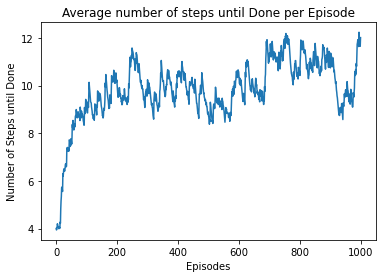

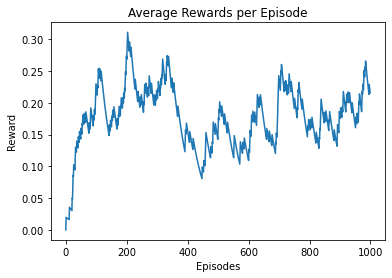

In [95]:
# Plot the performance
N_moves_save = pd.DataFrame(N_moves_save, columns = ['N_moves'])
N_moves_save['N_moves'] = N_moves_save['N_moves'].ewm(span=100, adjust=False).mean()


plt.plot(N_moves_save['N_moves'])
plt.xlabel('Episodes')
plt.ylabel('Number of Steps until Done')
plt.title('Average number of steps until Done per Episode')
plt.show()

R_save = pd.DataFrame(R_save, columns = ['R_save'])
R_save['R_save'] = R_save['R_save'].ewm(span=100, adjust=False).mean()

plt.plot(R_save)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Average Rewards per Episode')
plt.show()

In [13]:
# Q -learning

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
  
    
    while (Done==0 and i<50):                           ## START THE EPISODE
       
        Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, activfunction)  
        a=EpsilonGreedy_Policy(Qvalues,epsilon_f, allowed_a)
        S_next, X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            R_save[n,]=np.copy(R)
            print(i)
            N_moves_save[n,]=i
            print(N_moves_save[n,])
            
            delta=R-Qvalues[a]
            H = np.matmul(W1,X)+bias_W1
            W2[a,:]=W2[a,:]+eta*delta*H
            
            delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
            W1[:,:]=W1[:,:]+ eta*delta
        
            
            ## TO DO: update biases 
            break
       
  
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Qvalues1=ComputeQvalues(W1, W2, bias_W1, bias_W2, X_next, activfunction)
            a1=EpsilonGreedy_Policy(Qvalues1,0, allowed_a_next)

            # Compute the delta
            delta=R+gamma*Qvalues1[a1]-Qvalues[a]

            # Update the weights
            H = np.matmul(W1,X)+bias_W1
            W2[a,:]=W2[a,:]+eta*delta*H
            
            delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
            W1[:,:]=W1[:,:]+ eta*delta
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
       

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS



5
[5.]
3
[3.]
1
[1.]
28
[28.]
10
[10.]


C:\Users\adria\AppData\Local\Temp\ipykernel_59400\4002628119.py:11: RuntimeWarning: overflow encountered in matmul
  Qvalues = np.matmul(W2,X1)+bias_W2
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\3634133120.py:53: RuntimeWarning: invalid value encountered in multiply
  delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\4002628119.py:5: RuntimeWarning: invalid value encountered in matmul
  H1 = np.matmul(W1,X)+bias_W1 ## make sure that bias_W1 does not need to be transposed
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\3634133120.py:27: RuntimeWarning: invalid value encountered in matmul
  H = np.matmul(W1,X)+bias_W1


27
[27.]
1
[1.]
18
[18.]
37
[37.]
5
[5.]
5
[5.]
2
[2.]
37
[37.]
5
[5.]
3
[3.]
13
[13.]
14
[14.]
12
[12.]
14
[14.]
1
[1.]
9
[9.]
14
[14.]
1
[1.]
16
[16.]
11
[11.]
19
[19.]
22
[22.]
1
[1.]
21
[21.]
1
[1.]
15
[15.]
19
[19.]
3
[3.]
6
[6.]
1
[1.]
15
[15.]
7
[7.]
14
[14.]
1
[1.]
24
[24.]
36
[36.]
1
[1.]
3
[3.]
15
[15.]
30
[30.]
3
[3.]
7
[7.]
7
[7.]
27
[27.]
1
[1.]
34
[34.]
15
[15.]
15
[15.]
6
[6.]
27
[27.]
1
[1.]
1
[1.]
19
[19.]
31
[31.]
10
[10.]
1
[1.]
1
[1.]
1
[1.]
1
[1.]
45
[45.]
8
[8.]
13
[13.]
21
[21.]
17
[17.]
3
[3.]
19
[19.]
2
[2.]
22
[22.]
11
[11.]
12
[12.]
25
[25.]
12
[12.]
1
[1.]
10
[10.]
10
[10.]
1
[1.]
19
[19.]
15
[15.]
35
[35.]
24
[24.]
1
[1.]
10
[10.]
12
[12.]
4
[4.]
1
[1.]
7
[7.]
7
[7.]
31
[31.]
12
[12.]
7
[7.]
14
[14.]
5
[5.]
3
[3.]
1
[1.]
3
[3.]
45
[45.]
11
[11.]
18
[18.]
3
[3.]
6
[6.]
35
[35.]
2
[2.]
2
[2.]
16
[16.]
22
[22.]
2
[2.]
19
[19.]
4
[4.]
10
[10.]
21
[21.]
3
[3.]
3
[3.]
4
[4.]
9
[9.]
30
[30.]
1
[1.]
1
[1.]
14
[14.]
15
[15.]
1
[1.]
12
[12.]
4
[4.]
1
[1.]
3
[3.]
1
[1